Assessment 2: Appliance Classification



Programming Language: Python 3 in Jupyter Notebook

Python Libraries used:
- pandas
- sklearn
- numpy
- matplotlib
- seaborn
- xgboost
- itertools

#### Estimated runtime: 200-250 min

## Table of contents

1. [Introduction](#sec_1)
2. [Importing libraries and loading data](#sec_2)
3. [Exploration](#sec_3)
4. [Exploration Conclusions](#sec_4)
5. [Modelling](#sec_5)
6. [Conclusions](#sec_6)
7. [References](#sec_7)

## I. Introduction <a class="anchor" id="sec_1"></a>

The aim of this task is to develop classifiers to predict the state of different appliances (ac, ev, oven, wash and dryer), given aggregate data and extracted features about electricity consumption information and usage of individual appliances in residential buildings (Load). 

In order to achieve this, we will be completing the following steps:

* Importing and loading the data
* Exploring the data: in order to make findings about the variables distributions and their relationships that can help us at the time of building the different models.
* Modelling: taking into account what we found during exploration, we are going to build 2 different model types for each appliance: XGBoost and Random Forest classifiers. In this section we will go through a sequence of steps in order to improve our models performances, finally keeping the combination of models that yield the best overall performance.
* Making predictions on the test set using the models selected on the previous step.


## II. Importing libraries and loading data <a class="anchor" id="sec_2"></a>

In [ ]:
import pandas as pd
from itertools import chain
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, auc
from sklearn.ensemble import RandomForestClassifier
import sklearn
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from seaborn import FacetGrid
import seaborn as sns
from itertools import groupby
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, precision_recall_curve
from time import time

In [ ]:
# loading train data
train_data = pd.read_csv('train_data_withlabels.csv')
train_data.tail()

,Unnamed: 0,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst
417715,523256,2.543,0,0,0,0,0,21,Tue,-0.003,0.003,0.0,0.0,0.0,0.0,0.0
417716,523257,2.417,0,0,0,0,0,21,Tue,-0.126,0.126,0.0,0.0,0.0,0.0,0.0
417717,523258,0.999,0,0,0,0,0,21,Tue,-1.418,1.418,0.0,0.0,0.0,0.0,0.0
417718,523259,0.966,0,0,0,0,0,21,Tue,-0.033,0.033,0.0,0.0,0.0,0.0,0.0
417719,523260,0.964,0,0,0,0,0,21,Tue,-0.002,0.002,0.0,0.0,0.0,0.0,0.0


## III. Exploration <a class="anchor" id="sec_3"></a>

### Load distribution

First thing to do is to plot the distribution of the main predictor, which is load:

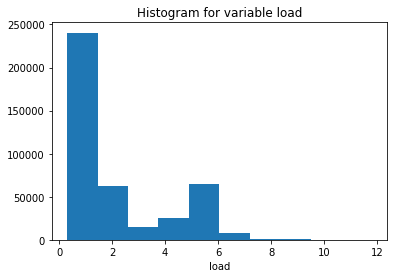

In [ ]:
# plotting histogram for variable load
plt.hist(train_data.load)
# title of the histogram
plt.title('Histogram for variable load')
# xlabel
plt.xlabel('load')
# display the plot
plt.show()

We can see that our variable does not follow a normal distribution. The majority of the values are small and that is why we can see that the distribution is positively skewed. Nevertheless, we are also able to see that we have a second smaller peak for larger values of load, which would make it harder to apply any of the obvious transformations to reduce the positive skewness, such as log transformation. Let's try it anyways, just to see how it goes:

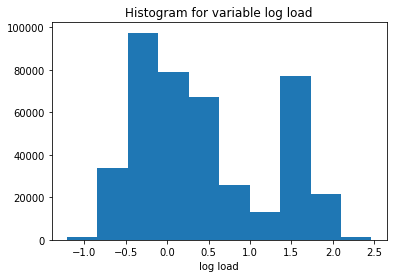

In [ ]:
# plotting histogram for variable load
plt.hist(np.log(train_data.load))
# title of the histogram
plt.title('Histogram for variable log load')
# xlabel
plt.xlabel('log load')
# display the plot
plt.show()

We can observe, just as we expected, how the second peak also emerges and the shape of our distribution is still not normal. We are then going to continue working with the original unstransformed data.

### Targets distributions

The next step is trying to understand how our targets are distributed, and how each of them is related to the predictors. This part is more tricky because our targets are binary variables. To be able to visualize their distributions, we will try to take them into continuous values. Two ways of doing this come to mind:

* Work with proportion of time the target is on. For this we will need to aggregate the data, by hour and day of the week for instance, and calculate the mean of each target. This will tell us what proportion of each hour the target is being used and will allow us to make comparisons between the different targets and plot the relationships with load.
* Work with amount of time the target stays on once on. This will be an average in minutes and will also help us start seeing more clearly which is the relation between load and the different targets.

#### Proportion of time targets are being used by hour of weeek

We are now going to develop the first approach stated above:

In [ ]:
# the outcome of this code cell will be a data frame with the average time of use of
# each artifact within each possible hour of every day of the week

# creating data frame to store the results
hour_day_df = pd.DataFrame()
# looping over each target
for target in ['ac', 'ev', 'oven', 'wash', 'dryer']:
    # grouping by hour and day and calculating the mean of each target (as they are binary the mean will
    # give us the average percentage of use within that hour)
    hour_day_df = pd.concat([hour_day_df, pd.DataFrame(train_data.groupby(['hourofday', 'dayofweek'], as_index = False)[target].mean())], axis = 1)
# eliminating duplicates
hour_day_df = hour_day_df.loc[:, ~hour_day_df.columns.duplicated()]
# aggregating load by hour and day
load_agg_df = train_data.groupby(['hourofday', 'dayofweek'], as_index = False)['load'].mean()
# merging both aggregated data frames (loads and percentage of use)
hour_day_load_df = pd.merge(load_agg_df, hour_day_df, on=['hourofday', 'dayofweek'])
# taking the resultant data frame to long format to be able to use it for plotting
hour_day_load_df_repeat = pd.DataFrame()
for target in ['ac', 'ev', 'oven', 'wash', 'dryer']:
    hour_day_load_df['target'] = target
    hour_day_load_df['average_time'] = hour_day_load_df[target]
    hour_day_load_df_repeat = pd.concat([hour_day_load_df_repeat, hour_day_load_df], axis = 0)
hour_day_load_df_repeat = hour_day_load_df_repeat.reset_index(drop=True)
# ordering days of the week
order = ['Mon' , 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
hour_day_load_df_repeat['dayofweek'] = pd.Categorical(hour_day_load_df_repeat['dayofweek'], order)
hour_day_load_df_repeat = hour_day_load_df_repeat.sort_values(['dayofweek', 'hourofday'])

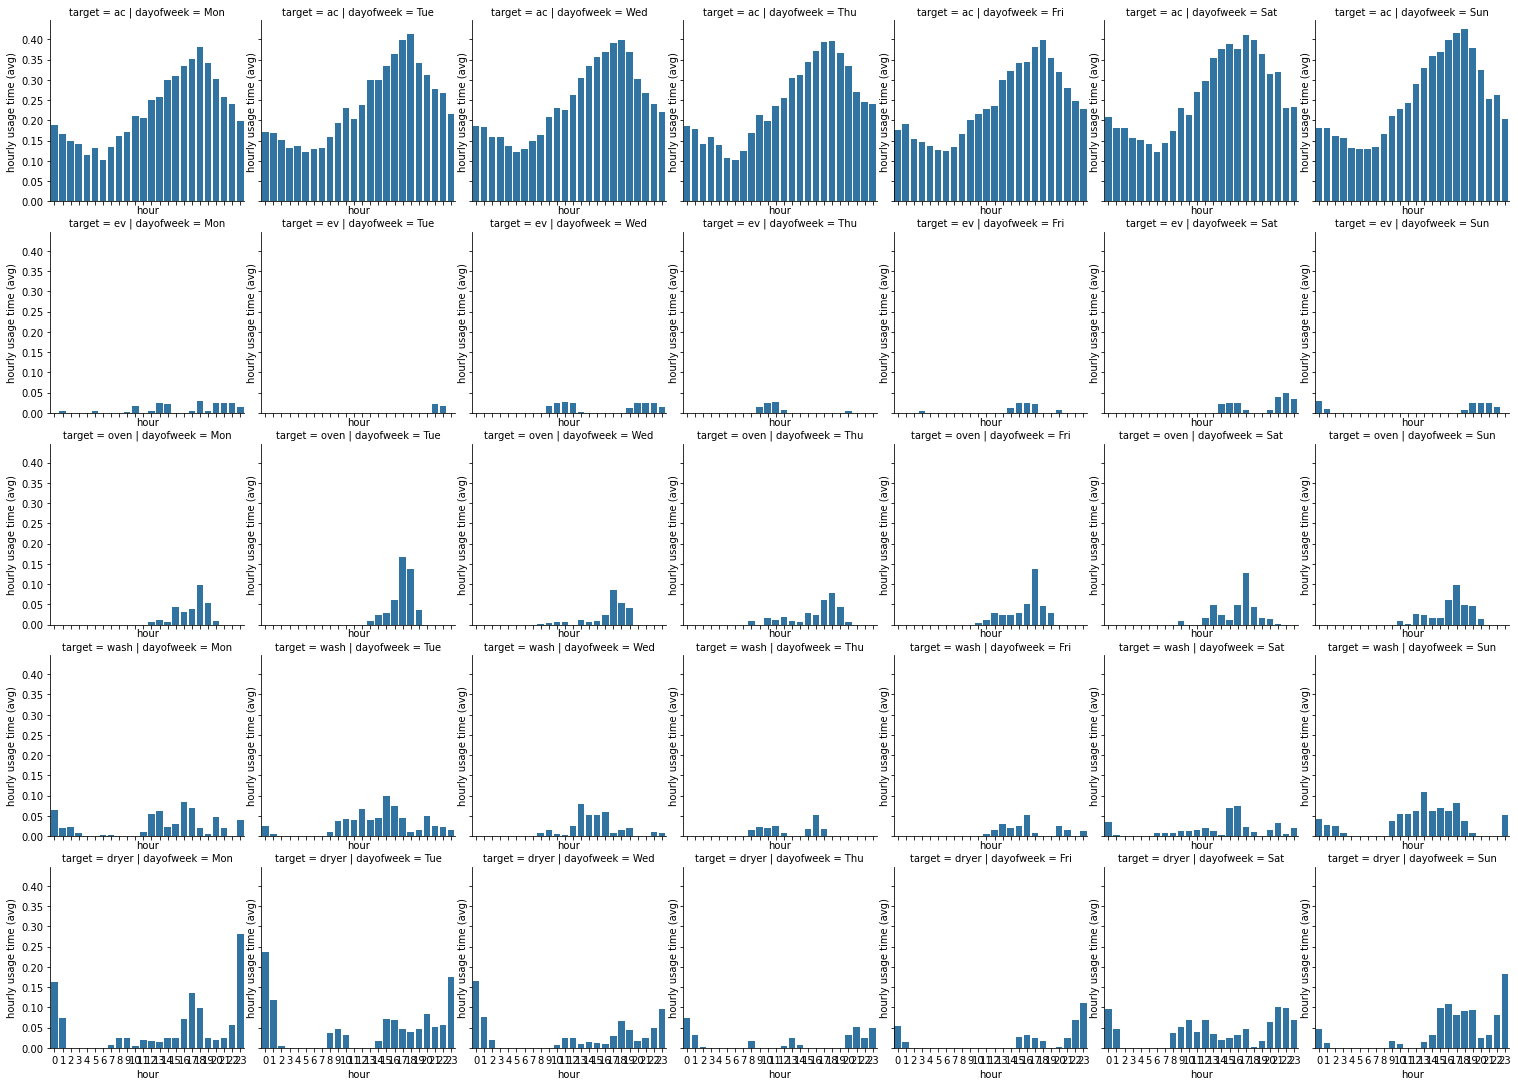

In [ ]:
# now plotting the values for the hourly proportion of use for each target, by day
g = sns.FacetGrid(hour_day_load_df_repeat, col="dayofweek",  row="target")
g.map_dataframe(sns.barplot, x="hourofday", y="average_time")
g.set(xlabel='hour', ylabel='hourly usage time (avg)')

We are already learning a few things with this plot:

* ac is by far the artifact that is being more used, and its hourly percentage of usage is almost identical each day.
* The other artifacts change slightly day by day but I believe the particular hour has more impact in the percentage of usage of each of the devices than the day itself.

Now we could try and see the relationships between the hourly percentage usage and the average of the load for each hour:

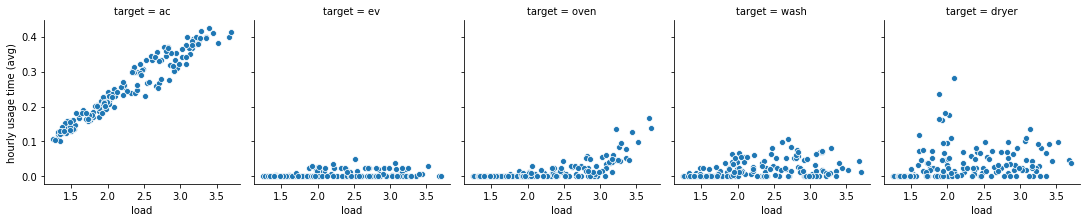

In [ ]:
# using Seaborn to plot
g = sns.FacetGrid(hour_day_load_df_repeat, col="target")
g.map_dataframe(sns.scatterplot, x="load", y="average_time")
g.set(xlabel='load', ylabel='hourly usage time (avg)')

We are able to observe a clear linear relationship between load and ac, while the others are harder to tell. All the others have several values with average 0, meaning that the devices are not being used at all in these hours (which confirms that the hour is something to take into account). The oven hourly percentage usage and load seem to display the principles of an exponential distribution, meaning that the load grows even for very small (or null) values of the oven usage (because other devices such as ac are being used for instance) but as soon as our load value is greater than 3, the oven usage time explodes. This might also be telling us that the oven's energy consumption is really big, and it will impact considerably on the load value once switched on.

And if the do the same analysis faceted by day?

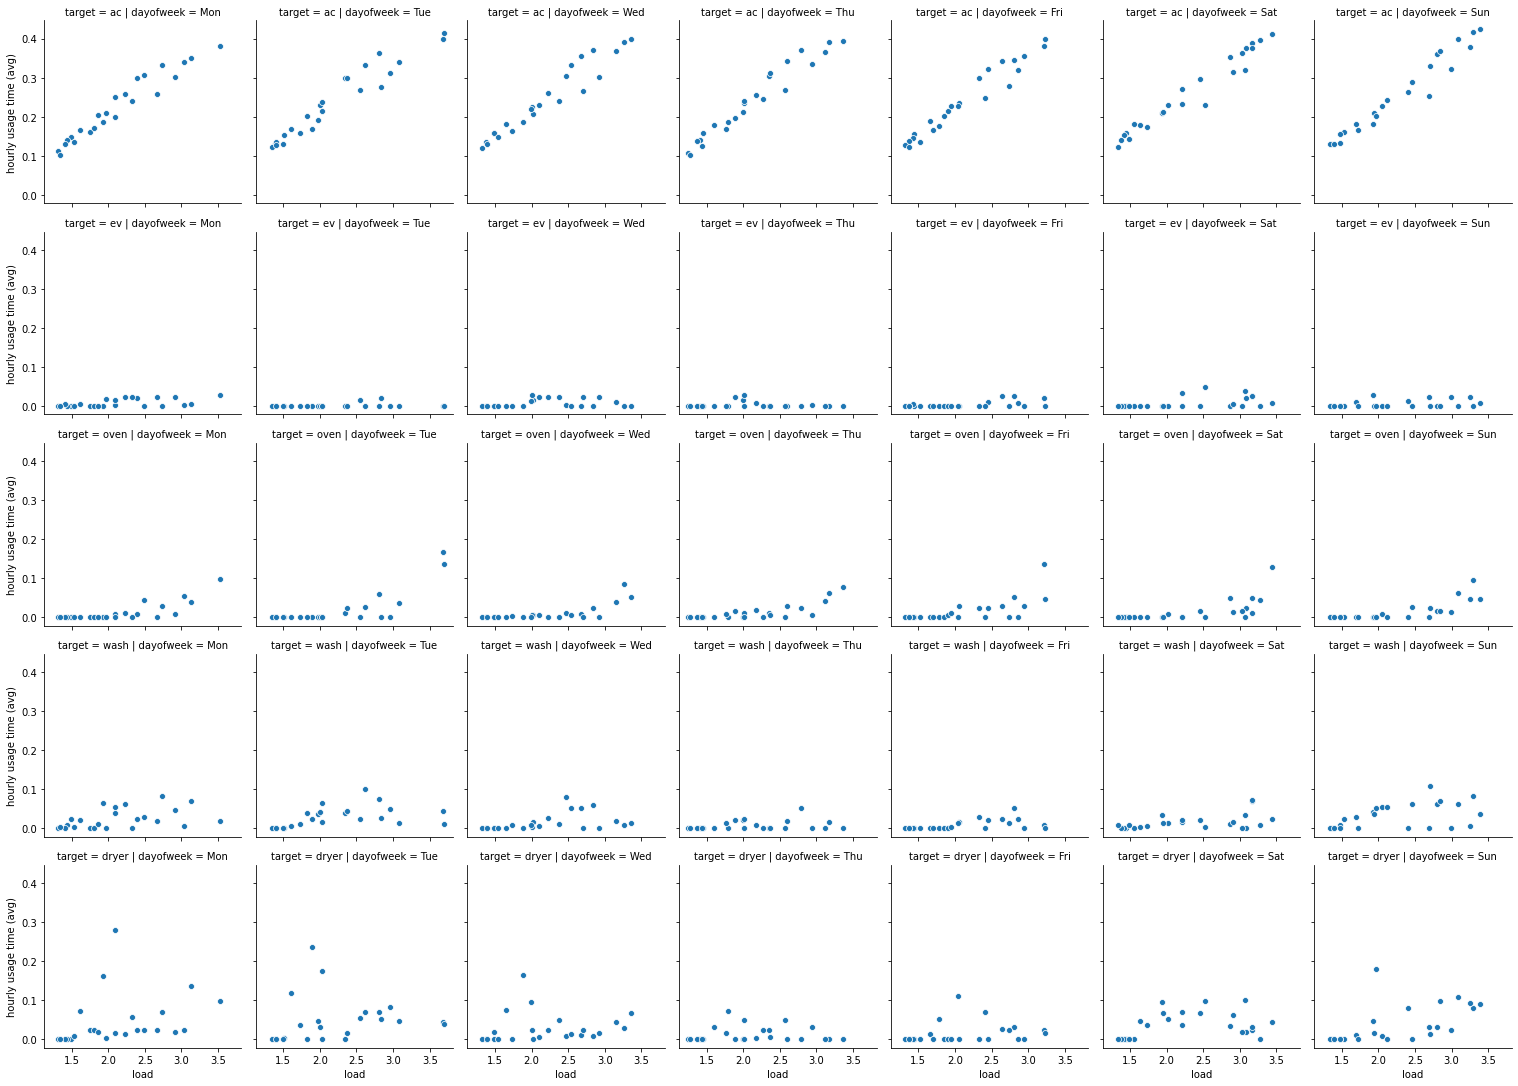

In [ ]:
# same thing but now faceted by dayofweek
g = sns.FacetGrid(hour_day_load_df_repeat, row="target", col = "dayofweek")
g.map_dataframe(sns.scatterplot, x="load", y="average_time")
g.set(xlabel='load', ylabel='hourly usage time (avg)')

We can see that the behaviours are pretty similar if we compare the different days of the week for each device.

Just to check further, we plot the values of load per hour for every day of the week:

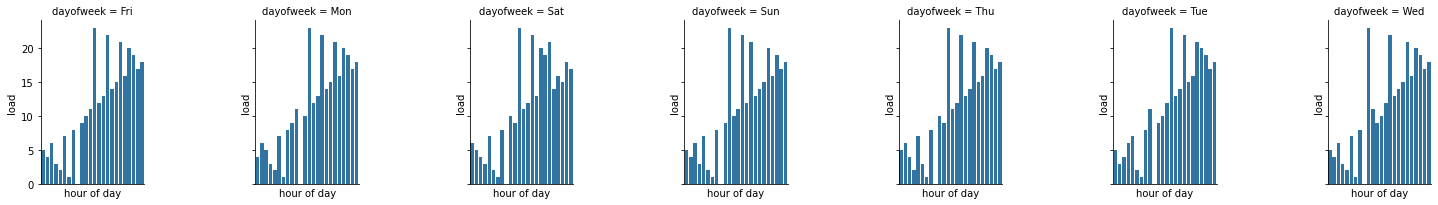

In [ ]:
g = sns.FacetGrid(hour_day_load_df, col="dayofweek")
g.map_dataframe(sns.barplot, x="load", y="hourofday")
g.set(xlabel='hour of day', ylabel='load')
# removing xticks for visual aesthetics purposes
g.set(xticks = [])

Still the same conclusion: the distribution among days is really similar, what seems to have an impact on the load value is actually the hour of the day.

#### Dividing by part of day

Having found that the different hours of the day have an impact both on the value of the final load as well as the percentage of usage of the different devices, we are going to divide the day in 4 parts: early morning, moring, afternoon, evening and night and perform a similar analysis using those categories:

In [ ]:
# performing the categorization into parts of day
hour_day_load_df_repeat.loc[(hour_day_load_df_repeat.hourofday>0) & (hour_day_load_df_repeat.hourofday<=6), 'partofday'] = 'early morning'
hour_day_load_df_repeat.loc[(hour_day_load_df_repeat.hourofday>6) & (hour_day_load_df_repeat.hourofday<=11), 'partofday'] = 'morning'
hour_day_load_df_repeat.loc[(hour_day_load_df_repeat.hourofday>11) & (hour_day_load_df_repeat.hourofday<=15), 'partofday'] = 'afternoon'
hour_day_load_df_repeat.loc[(hour_day_load_df_repeat.hourofday>15) & (hour_day_load_df_repeat.hourofday<=20), 'partofday'] = 'evening'
hour_day_load_df_repeat.loc[(hour_day_load_df_repeat.hourofday>20) & (hour_day_load_df_repeat.hourofday<=23), 'partofday'] = 'night'

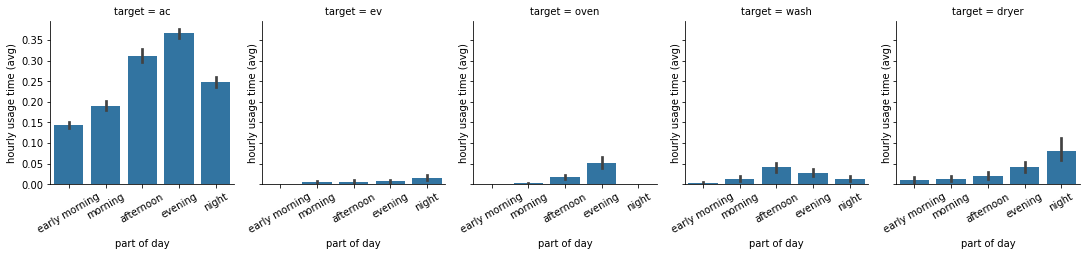

In [ ]:
# grid containing all the plots
g = sns.FacetGrid(hour_day_load_df_repeat, col="target")
g.map_dataframe(sns.barplot, x="partofday", y="average_time")
g.set(xlabel='part of day', ylabel='hourly usage time (avg)')
g.set_xticklabels(rotation=30)

We will also plot one by one to be able to zoom out the ones that have smaller values:

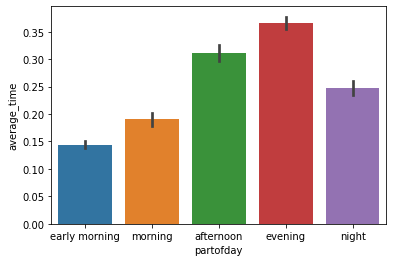

In [ ]:
# for ac
ax = sns.barplot(x="partofday", y="average_time", data=hour_day_load_df_repeat[hour_day_load_df_repeat.target=='ac'])

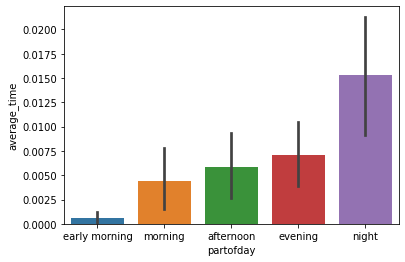

In [ ]:
# for ev
ax = sns.barplot(x="partofday", y="average_time", data=hour_day_load_df_repeat[hour_day_load_df_repeat.target=='ev'])

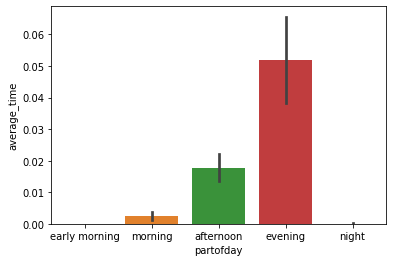

In [ ]:
# for oven
ax = sns.barplot(x="partofday", y="average_time", data=hour_day_load_df_repeat[hour_day_load_df_repeat.target=='oven'])

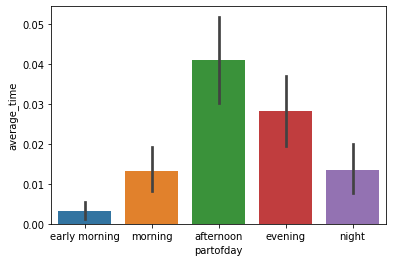

In [ ]:
# for wash
ax = sns.barplot(x="partofday", y="average_time", data=hour_day_load_df_repeat[hour_day_load_df_repeat.target=='wash'])

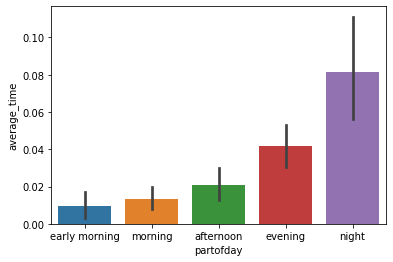

In [ ]:
# for dryer
ax = sns.barplot(x="partofday", y="average_time", data=hour_day_load_df_repeat[hour_day_load_df_repeat.target=='dryer'])

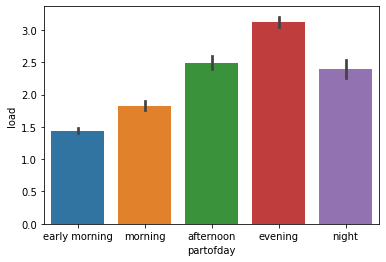

In [ ]:
# finally the load values segregated by part of day (the target is set to wash but it could have been set
# equal to any target, as it is the data in the long format, the information about load is repeated for each
# target)
ax = sns.barplot(x="partofday", y="load", data=hour_day_load_df_repeat[hour_day_load_df_repeat.target=='wash'])

By taking a look at these plots we can reach the following conclusions:

* load and ac have almost the same distribution regarding the parts of the day: the ac hourly proportion of use gradually increases from early moring to evening and then drops at night, so as does the average load value.

* The others have their own behaviours: dryer and ev usage gradually increases as the day transpires, wash has almost a normal shape centered in the afternoon, etc.

This gives us the idea that this categorical variable might be worth including in our final model as it clearly encodes patterns among all of the targets behaviours.

#### Minutes of usage once devices are switched on

Now let's try to follow the second approach we defined when we were talking about being able to transform the binary targets into continuous values. We are going to calculate the values in minutes for each time a device switches from 0 to 1 (by adding all the ones, it will give us the length in minutes) and plot these distributions for each artifact:

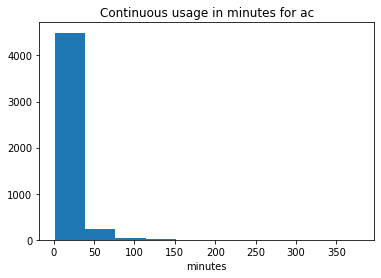

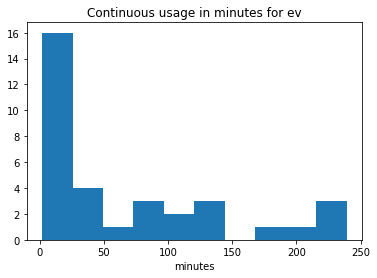

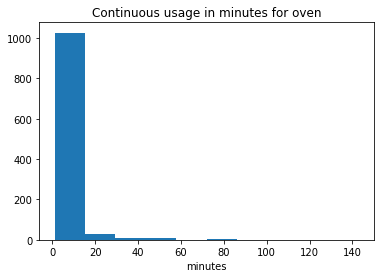

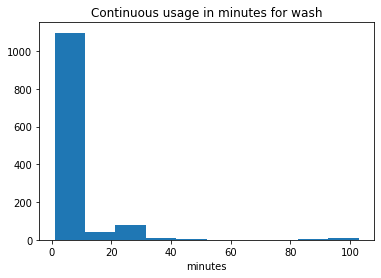

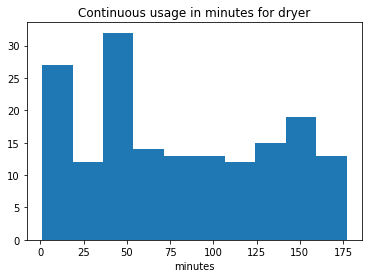

In [ ]:
# initializing a dictionary that will store the duration values in minutes for
# each device once switched on
continuous_use_dict = dict()
targets = ['ac', 'ev', 'oven', 'wash', 'dryer']
# looping all the targets
for target in targets:
    # grouping by into equal values (ones in this case) and summing them up
    list_of_continuous_use = [sum(1 for i in g) for k,g in groupby(train_data[target]) if k==1]
    # storing into dictionary
    continuous_use_dict[target] = list_of_continuous_use
    # plotting each target
    plt.hist(list_of_continuous_use)
    plt.title('Continuous usage in minutes for ' + target)
    plt.xlabel('minutes')
    plt.show()

We are able to see that the wash and oven are generally being used for very short periods of time. ac also has a very large peak at a small value but the x-axis ticks are larger so we would expect an average time of use a little larger than the other 2. Finally, ev and specially dryer are being used in a wider range of lengths once switched on.

Let's try to get the mean for the times of use for each artifact (calculating it with all the values of each session they were on):

In [ ]:
for target,list_of_use in continuous_use_dict.items():
    print('The', target, 'is used', round(np.mean(list_of_use), 2), 'minutes in average once turned on.')

The ac is used 21.09 minutes in average once turned on.
The ev is used 68.68 minutes in average once turned on.
The oven is used 5.54 minutes in average once turned on.
The wash is used 6.37 minutes in average once turned on.
The dryer is used 79.86 minutes in average once turned on.


In [ ]:
for target,list_of_use in continuous_use_dict.items():
    print('The', target, 'has been used', len(list_of_use), 'different times through the given period.')

The ac has been used 4799 different times through the given period.
The ev has been used 34 different times through the given period.
The oven has been used 1076 different times through the given period.
The wash has been used 1249 different times through the given period.
The dryer has been used 170 different times through the given period.


This information, together with the one regarding the proportion of usage within each hour allows us to see:

* ac is being frequently used with a medium length, giving the higher proportion of usage within an hour as we have already seen.
* wash and oven are being frequently used but for short periods of time.
* dryer and ev have been used few times but for much longer periods of time.

All this information will help us building an overall profile of all the targets and relate them to the main predictor.

But first, let's see if the average time a device stays on changes with the part of the day:

In [ ]:
# doing the same thing than above but now subsetting with part of day and finally storing in a data frame
i = 0
usage_df = pd.DataFrame()
# adding class into original data (before it was added in the long format data frame)
train_data.loc[(train_data.hourofday>=0) & (train_data.hourofday<=6), 'partofday'] = 'early morning'
train_data.loc[(train_data.hourofday>6) & (train_data.hourofday<=11), 'partofday'] = 'morning'
train_data.loc[(train_data.hourofday>11) & (train_data.hourofday<=15), 'partofday'] = 'afternoon'
train_data.loc[(train_data.hourofday>15) & (train_data.hourofday<=20), 'partofday'] = 'evening'
train_data.loc[(train_data.hourofday>20) & (train_data.hourofday<=23), 'partofday'] = 'night'
for target in targets:
    for part_of_day in train_data.partofday.unique():
        # subsetting with part of day category
        train_subset = train_data[train_data.partofday==part_of_day]
        # calculating the number of minutes a particular device stays on for all the
        # sessions in a particular part of the day
        list_of_continuous_use = [sum(1 for i in g) for k,g in groupby(train_subset[target]) if k==1]
        # storing in data frame to be able to plot
        usage_df.loc[i, 'target'] = target
        usage_df.loc[i, 'partofday'] = part_of_day
        usage_df.loc[i, 'minutes_usage'] = np.mean(list_of_continuous_use)
        i += 1

/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# fillna because some of the devices are not being used in a particular part of the day
# and then the returned value is na
usage_df = usage_df.fillna(0)
usage_df.head()

,target,partofday,minutes_usage
0,ac,early morning,13.820242
1,ac,morning,15.783810
2,ac,afternoon,25.113689
3,ac,evening,33.421218
4,ac,night,17.500680


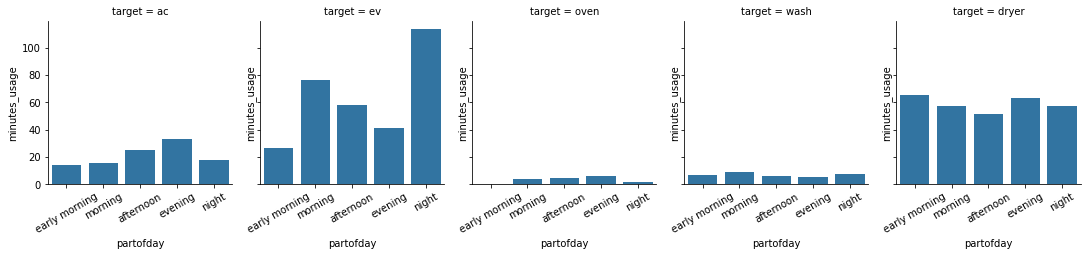

In [ ]:
# plotting
g = sns.FacetGrid(usage_df, col="target")
g.map_dataframe(sns.barplot, x="partofday", y="minutes_usage")
g.set(xlabel='partofday', ylabel='minutes_usage')
g.set_xticklabels(rotation=30)

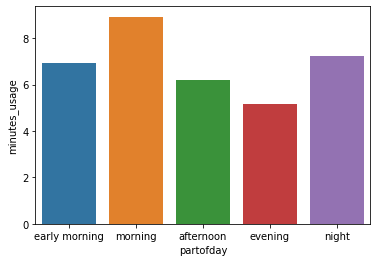

In [ ]:
# Zooming wash to be able to understand it better
ax = sns.barplot(x="partofday", y="minutes_usage", data=usage_df[usage_df.target=='wash'])

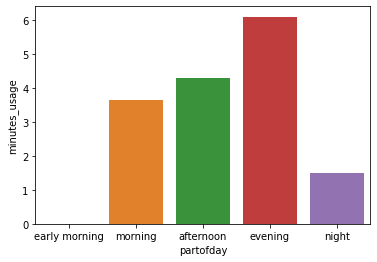

In [ ]:
# zooming oven to be able to understand it better
ax = sns.barplot(x="partofday", y="minutes_usage", data=usage_df[usage_df.target=='oven'])

We are able to observe that some of the targets such as oven or ev are more sensible to the part of the day with regards of the minutes of usage while others such as dryer or wash have a more consistent length of usage throughout the day.

### Changes in load for changes in the targets

Now that we know how frequent and how long is the usage of each device, we would like to find out how this usage really affects the load value, which I believe to be very helpful when modelling. That is why, we will measure the mean values of the variation of load (given by the absdiff column) for each of the following possible actions in the targets:
* 0-0 relation (off-off): the target was switched off and is still switched off.
* 1-1 relation (on-on): the target was switched on and is still switched on.
* 0-1 relation (off-on): the target switches on. It's important to remark that this change of state is only composed by one instance, unlike the above 2 that can (and often will) be composed of several contiguous instances in which the artifact remains on, or remains off.
* 1-0 relation (on-off): the targets switches off. Same as the previous relation, this one is only composed by one instance: the one in which the device effectively switches off.

An example to understand how it works: let's say we have the first 30 minutes in which the ac was off: we calculate the mean in the difference of each instance with regards to the previous one for those 30 minutes. Then it switches on in minute 31, we use that value of load difference as 0-1 relation. For all the subsequent values for which the ac is on (let's say 5 minutes), we average the load differences and get 1-1 relation. Finally, when the ac is off, we store the load difference between the instance after switching it off and the previous one in which it was on. We do this independently for each session of on-off and we will end up with 4 lists of values for each target, that we then can average and make conclusions.

The intuition behind this idea is that we should have larger absolute values for 0-1 relations and 1-0 relations (the first one positive and the second negative) than for 0-0 and 1-1 relationships because switching on or off a device should increase or decrease the load with respect to the previous instant, while maintaining the device in the same status shouldn't (load can still change because there are other devices also affecting it, but that's another story). We will also be able with this to have an idea of how each target affects the load value, which in the end is what we need to make the predictions.

In [ ]:
# generate a dictionary for each type of relation
# we will end up storing the target's results for each
on_on_dict = dict()
off_on_dict = dict()
on_off_dict = dict()
off_off_dict = dict()
for target in targets:
    # lists that will be the values of the above dictionaries
    on_on_load = []
    off_on_load = []
    on_off_load = []
    off_off_load = []
    i=0
    j=0
    # this array gives us the indexes in which a new sequence of 0's or 1's start
    on_off_array = np.cumsum([sum(1 for i in g) for k,g in groupby(train_data[target])])
    # looping over all these indexes
    for index in on_off_array:
        if i < len(on_off_array)-1:
            # on_on will be the mean of the differences when the device is switched on (except for first one
            # and last one because these capture 0-1 and 1-0 respectively)
            on_on_load.append(np.mean(train_data.loc[(on_off_array[i]+2):(on_off_array[i+1]-1), 'absdif']))
            # 0-1 relation as the absdiff between the first 1 and the last 0 of the previous sequence
            off_on_load.append(train_data.loc[on_off_array[i], 'absdif'])
            # 1-0 relation as the absdiff between the first 0 and the last 1 of the previous sequence
            on_off_load.append(train_data.loc[on_off_array[i+1], 'absdif'])
            i+=2
        if j != 0 and j < len(on_off_array)-1:
            # same thing with zeros but using odd indexes
            off_off_load.append(np.mean(train_data.loc[(on_off_array[j-1]+1):(on_off_array[j]-1), 'absdif']))
            j +=2
        else:
            # first instances are 0 for all the targets
            off_off_load.append(np.mean(train_data.loc[0:(on_off_array[0]-1), 'absdif']))
            j +=2
    # removing nan values for values that are only 1 sequence long (switched on for one minute only,
    # which will not give us 1-1 relation)   
    on_on_load = [round(load_mean,4) for load_mean in on_on_load if np.isnan(load_mean)==False]
    off_off_load = [round(load_mean,4) for load_mean in off_off_load if np.isnan(load_mean)==False]
    # storing everything in corresponding dictionaries
    on_on_dict[target] = on_on_load
    off_on_dict[target] = off_on_load
    on_off_dict[target] = on_off_load
    off_off_dict[target] = off_off_load                            

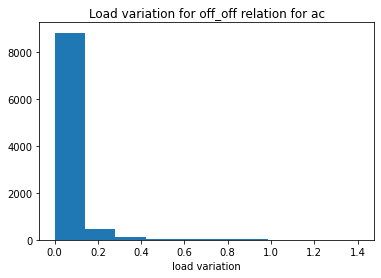

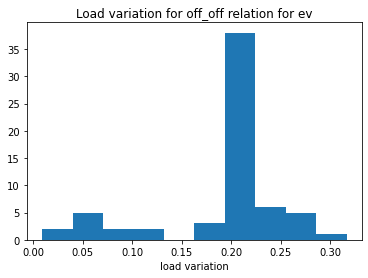

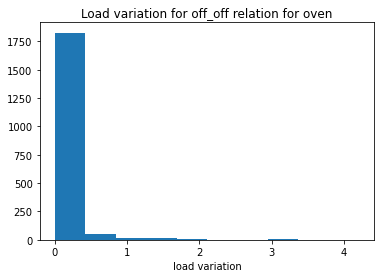

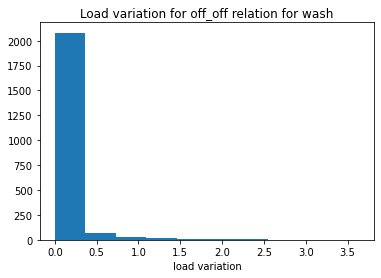

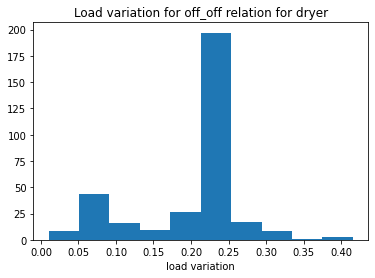

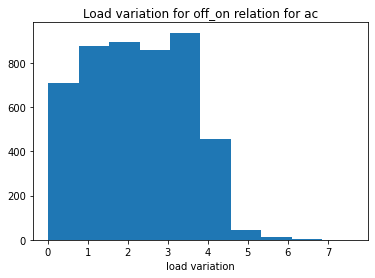

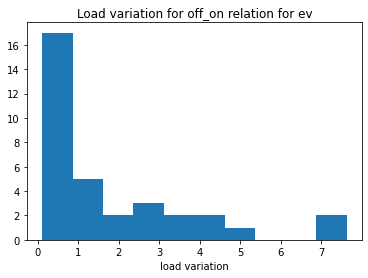

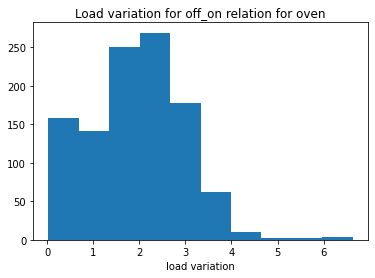

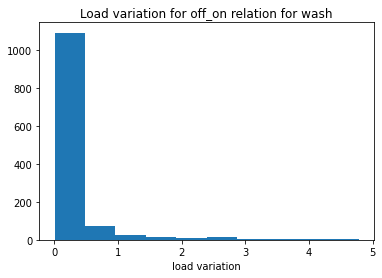

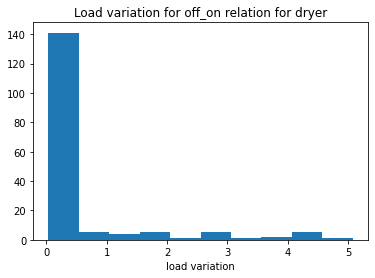

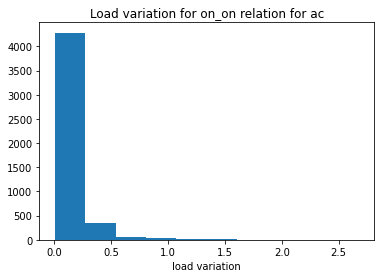

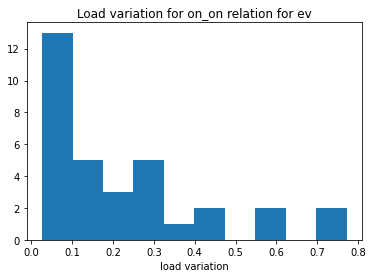

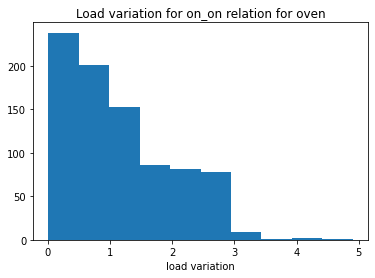

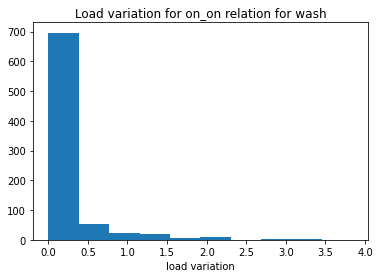

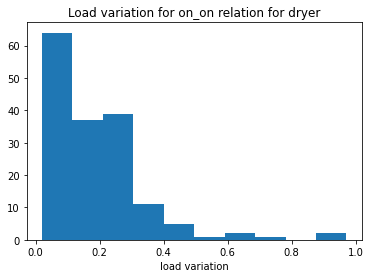

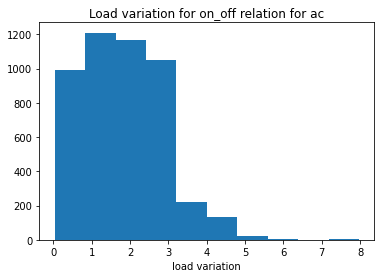

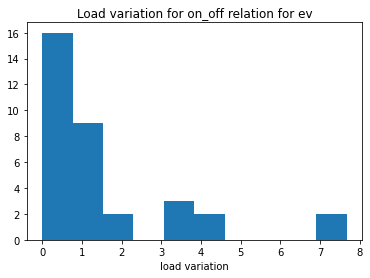

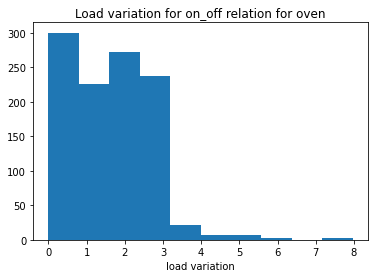

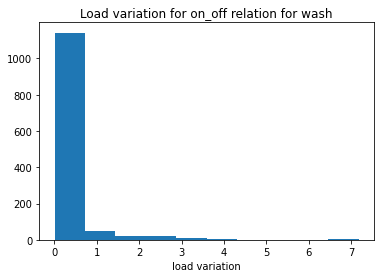

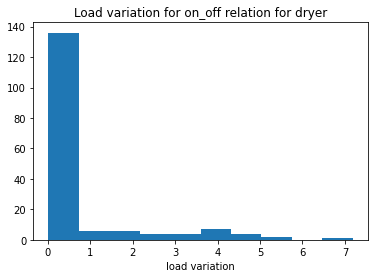

In [ ]:
# looping over all the results so we can retrieve a data frame with the mean values so
# we have an idea of what is going on
list_of_dictionaries = [off_off_dict, off_on_dict, on_on_dict, on_off_dict]
# data frame
load_target_relationships = pd.DataFrame()
# index of data frame
i = 0
for relation_dict in list_of_dictionaries:
    # just labeling the different types of relation
    if relation_dict == off_off_dict:
        rel = 'off_off'
    elif relation_dict == off_on_dict:
        rel = 'off_on'
    elif relation_dict == on_on_dict:
        rel = 'on_on'
    elif relation_dict == on_off_dict:
        rel = 'on_off'
    for target,relation in relation_dict.items():
        # looping over keys and values of dictionaries and storing
        # results as mean in the data frame
        load_target_relationships.loc[i, 'target'] = target
        load_target_relationships.loc[i, 'relation'] = rel
        load_target_relationships.loc[i, 'mean_load_variation'] = np.mean(relation)
        i += 1
        # plotting all the targets and relations
        plt.hist(relation)
        plt.title('Load variation for ' + rel + ' relation for ' + target)
        plt.xlabel('load variation')
        plt.show()

In [ ]:
# retrieving ordered data frame
load_target_relationships.sort_values(by=['mean_load_variation'], ascending = False)

,target,relation,mean_load_variation
5,ac,off_on,2.240559
7,oven,off_on,1.932414
15,ac,on_off,1.829806
6,ev,off_on,1.682500
17,oven,on_off,1.629404
16,ev,on_off,1.524647
12,oven,on_on,1.144179
19,dryer,on_off,0.787235
9,dryer,off_on,0.660218
18,wash,on_off,0.317157


We can see that, in a general sense, switching on and off a device affects more the load than maintaining the device in its current state, which is as we suspected. 

ac seems to have the most influence in the variation of the load, followed by oven and ev. The dryer and lastly the wash seem to have less impact in the load variation.

ac's own load variation values are very well distinguished between the 4 types of actions. It's also the case (less but still) for ev and oven. This will certainly make the prediction easier because the model will be able to capture the different states of the target more easily. On the other hand, wash values are all very similar and relatively small, which means that it is going to be more difficult to distinguish between the different states of the variable, by analyzing the load.

wash, dryer, oven and ev have really similiar off_off values and different than ac. I believe this is due to the fact that a lot of the time these 4 are disconnected, ac is still connected, and their off-off value is actually increased by the on_on value for ac (and any other device that can be functioning simoultaneously). If we take a look at the ac off_off value is way smaller, and this is because much of the time ac is disconnected, the other area as well, bringing the value closer to 0.

## IV. Exploration Conclusions <a class="anchor" id="sec_4"></a>

The exploration has allowed us to say the following about the attributes of the data:

* ac is definitely the device that is being more frequently used and the one with the highest hourly proportion of usage. We also found it to be the target responsible for the largest variations in the load variable. We have discovered as well that there is a straight linear relationship between the proportion of use of this variable and the hourly load mean.
* ev is the device less frequently used but it is usually used for large periods of time once switched on. Its contribution to the variability of load whenever it is turned on or off is also considerable.
* dryer is similar to ev but more frequently used and used for even larger periods of time, giving a larger hourly proportion of use than ev (but smaller than ac). Its contribution to the variation of load is really small meaning that we don't observe meaningful variations when its value changes .
* wash is being used really frequently but for small periods of time. Its contribution to the variation of load is the most insignificant. All of this characteristics I believe will make this variable the hardest to predict.
* oven is also being used frequently but for short periods of time. A change in its state considerably affects the load, such as with ac and ev.
* days of the week have not as much effect in the distribution of the targets and the load as hours of the day. That is why we decided to introduce a new categorical variable refering to the part of the day that we are going to use while modelling. 

## V. Modelling <a class="anchor" id="sec_5"></a>

In this part we will build 2 different models per every application. In order to achieve this, we completed the following steps:

* Building, training, evaluating and comparing basic versions of XGBoost and Random Forest Classifiers.
* Calculating the optimal threshold for each application, for both models, using the precision-recall approach for maximizing the F1-score, to help us overcome the class imbalance. We then trained and evaluated each model using the new optimal thresholds.
* Assessing feature importance and selecting accordingly a subset of features for each model to boost its performance.
* Hyperparameter tuning.
* Window size tuning: deciding how many previous and posterior instances of the load variable to include to train each data point, taking into account the average times of each appliance that we calculated during exploration.
* Pre-processing test set to eliminate features and adding window features according to train performances.
* Performing predictions on test set.

In [ ]:
# a quick look at the data, to remember that we have added one extra attribute: partofday
train_data

,Unnamed: 0,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst,partofday
0,105541,2.245,0,0,0,0,0,0,Sun,0.987,0.987,6.215,3.074549,0.678886,0.052903,0.994071,early morning
1,105542,2.259,0,0,0,0,0,0,Sun,0.014,0.014,6.215,3.172867,0.667450,0.054829,0.994154,early morning
2,105543,2.269,0,0,0,0,0,0,Sun,0.010,0.010,6.215,3.270112,0.647777,0.056991,0.994220,early morning
3,105544,2.268,0,0,0,0,0,0,Sun,-0.001,0.001,6.215,3.303763,0.629227,0.057606,0.994150,early morning
4,105545,2.270,0,0,0,0,0,0,Sun,0.002,0.002,6.215,3.302744,0.621295,0.082640,0.994041,early morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417715,523256,2.543,0,0,0,0,0,21,Tue,-0.003,0.003,0.000,0.000000,0.000000,0.000000,0.000000,night
417716,523257,2.417,0,0,0,0,0,21,Tue,-0.126,0.126,0.000,0.000000,0.000000,0.000000,0.000000,night
417717,523258,0.999,0,0,0,0,0,21,Tue,-1.418,1.418,0.000,0.000000,0.000000,0.000000,0.000000,night
417718,523259,0.966,0,0,0,0,0,21,Tue,-0.033,0.033,0.000,0.000000,0.000000,0.000000,0.000000,night


### Train function

The following is the function that will be used to train and evaluate each model. In order not to repeat code over and over, this function includes the following:

* data pre-processing: adds instances of load variable as new features to current row according to window specification (if window = 0, the original training dataset is used).
* removes features from the data if specified.
* allows threshold specification for binary prediction.
* data splitting using validation set approach (to avoid using cross validation because of sequence data and size).
* model training.
* printing results.
* saving results in a global data frame, (one after the other as the function is called).
* saving trained models in a dictionary for further use.

In [ ]:
# defining function to train models
def train_validate_models(model, train_data, target, windows, p, features_to_remove, hyperparameters, threshold):
    
    # parameters:
    # model: model to train
    # train_data: complete training data
    # target
    # windows: number of previous and posterior data points to be included as features in each row
    # p: if we want to work with a proportion of the data, to train faster
    # features_to_remove: columns to drop from the data
    # hyperparameters: hyperparameters that are being tuned (only for printing purposes, the hyperparameter
    # declaration will already come from the model variable)
    # threshold: threshold to predict positive instances
    
    # index as length of performance data frame to append new results
    i = len(performance_df)
    # if we want to work with windows
    for window in windows:
        if window !=0:
            # we just call the window loads function to add the load values as new features for each data point
            windows_data_df = window_loads(window, train_data)
            # just in case we want to work with a subset of the data to make training faster
            train = windows_data_df.loc[:len(train_data)*p, :]
        else:
            # if no window, we just work with the original data
            # just in case we want to work with a subset of the data to make training faster
            train = train_data.loc[:len(train_data)*p, :]
        # if we want to remove some specific features
        if features_to_remove != None:
            x_features = list(train.iloc[:, np.r_[1,7:len(train.columns)]].columns)
            for feature_to_remove in features_to_remove:
                x_features.remove(feature_to_remove)
            # our x_train will contain only non-removed features
            x_train = train.loc[:, x_features]
            # transforming categorical variables to numerical
            if 'partofday' not in features_to_remove and 'dayofweek' not in features_to_remove:
                x_train = pd.get_dummies(x_train, columns=['dayofweek', 'partofday'], drop_first=True)
            elif 'dayofweek' not in features_to_remove and 'partofday' in features_to_remove:
                x_train = pd.get_dummies(x_train, columns=['dayofweek'], drop_first=True)
            elif 'dayofweek' in features_to_remove and 'partofday' not in features_to_remove:
                x_train = pd.get_dummies(x_train, columns=['partofday'], drop_first=True)
        # if there aren't specified features to remove we just work with the whole data
        else:
            x_train = train.iloc[:, np.r_[1,7:len(train.columns)]]
            # x_train = train.iloc[:, 1:]
            x_train = pd.get_dummies(x_train, columns=['dayofweek', 'partofday'], drop_first=True)
        # defining the target data
        ytrain = train[target]
        # splitting the data into train and validation
        X_train, X_test, y_train, y_test = train_test_split(x_train, ytrain, test_size=0.2, random_state = 1)
        # training the model
        model_name = model.__class__.__name__
        # fit the model
        model.fit(X_train, y_train)
        # predict as probabilities, to be able to make use of threshold
        y_prob = model.predict_proba(X_test)
        # we keep the positive class probabilities (1-negatives)
        positive_probs = [y_prob[i][1] for i in range(len(y_prob))]
        # we make the prediction according to the threshold, default = 0.5
        prediction = (np.array(positive_probs) >= threshold).astype(int)
        # calculating fscore, recall and precision
        f1_score = sklearn.metrics.f1_score(y_test, prediction)
        recall= sklearn.metrics.recall_score(y_test, prediction)
        precision=precision_score(y_test, prediction)
        # printing results
        print(model_name, ' ', 'Target:', target, ', Window_size:', window,'\n', 'Column removed:',str(features_to_remove),'\n','Threshold:', threshold, ', Hyperparameters Tuning:',str(hyperparameters), '\n', 'f1score: ', f1_score ,'\n', 'recall: ', recall ,'\n', 'precision: ', precision ,'\n', confusion_matrix(y_test, prediction))
        # storing unique model_id with trained model to dictionary
        model_id = str(model_name) + '_' + target+'_'+ str(window) + '_no_' + str(features_to_remove)+'_' + str(hyperparameters)+'_'+'threshold'+str(threshold)
        # storing results in data frame
        performance_df.loc[i, 'target'] = target
        performance_df.loc[i, 'model'] = model_name
        performance_df.loc[i, 'model_id'] = model_id
        performance_df.loc[i, 'window_size'] = window
        performance_df.loc[i, 'f1_score'] = round(f1_score,4)
        performance_df.loc[i, 'recall'] = round(recall,4)
        performance_df.loc[i, 'precision'] = round(precision,4)
        performance_df.loc[i, 'threshold'] = threshold
        performance_df.loc[i, 'eliminated_feature'] = str(features_to_remove)
        performance_df.loc[i, 'hyperparameter_tuning'] = str(hyperparameters)
        i += 1
        # saving model into dictionary
        trained_model_dict[model_id] = model
        # storing probs and y_test in dictionary to be able to calculate thresholds
        if model_name == 'XGBClassifier':
            predictions_xgb[target] = [y_test, positive_probs]
        else:
            predictions_rf[target] = [y_test, positive_probs]

### Window loads function

This function adds the n previous and posterior loads instances to each row (except the first and last ones) as specified by the window parameter. We are going to use it further on to boost our models performances. We define it here because it is called inside the training function (but we will not activate it yet).

In [ ]:
# it will return a data frame with appended values of previous and posterior values of load as features
def window_loads(window, train_data):
    # list to store the indexes of the instances that will go in the same row according to window parameter
    list_of_indexes = []
    # retrieving indexes with bandas built in function rolling
    train_data.load.rolling(2*window+1, center=True).apply(lambda x: list_of_indexes.append(list(x.index)) or 0, raw=False)
    # list of indexes
    window_indexes = list(chain.from_iterable(list_of_indexes))
    # data frame with the repeated instances, as required
    train_data_windows = train_data.iloc[np.r_[window_indexes], :]
    # giving an id to each set of rows that will be grouped together within a window
    id_list =[]
    j = 0
    for i in range(1, len(train_data_windows), (2* window + 1)):
        id_list += [j]*(2*window + 1)
        j+=1
    train_data_windows['id'] = id_list
    # splitting the data according to the ids grouping each window
    window_loads_array = np.split(np.array(train_data_windows.load), len(train_data_windows.id.unique()))
    train_data_subset = train_data.loc[(window):(len(train_data)-window -1)].reset_index(drop=True)
    # creating new columns that will contain the past and future loads instances as new features
    for j in range(1,2*window + 2):
        train_data_subset['load'+str(j)] = 0
    # assigning the loads
    train_data_subset.iloc[:, -(window*2 + 1):] = window_loads_array
    # droping the column containing the added load corresponding to the same instance
    train_data_subset = train_data_subset.drop(columns = [train_data_subset.columns[-(window +1)]])
    return(train_data_subset)

### Basic Models

First we will start training the basic default versions of XGBoost and Random Forest in order to get a sense of their general performances.

We first initialize a Data Frame that will store the overall performance for each model type in each step of the procedure (as the mean across the F-scores of the best-performing models for that model type at the time of the particular step) as well as the best-performing combination of both models at a particular stage. 

In [ ]:
evolution_performance_df = pd.DataFrame()

And now we start training the basic versions of both algorithms:

In [ ]:
# creating dictionaries that will store the predictons during training
predictions_xgb = dict()
predictions_rf = dict()

# targets
targets = ['ac', 'ev', 'oven', 'wash', 'dryer']
# data frame that will store all the results
performance_df = pd.DataFrame()
# dictionay that will store the trained models
trained_model_dict = dict()
models = [XGBClassifier(use_label_encoder=False, eval_metric = 'logloss'), RandomForestClassifier()]

# As specified above, the training function has the option to remove features, choose hyperparameters to tune and
# also choose the size of the window. For the moment we won't use any of this, because we will
# run the very basic versions of both models

features_to_remove = None
hyperparameters_to_tune = None
windows = [0]
# default threshold to start
threshold = 0.5

# creating 2 models for each target and printing results
for target in targets :
    for model in models:
        model_name = model.__class__.__name__
        train_validate_models(model, train_data, target, windows, 1, features_to_remove, hyperparameters_to_tune, threshold)
        print('\n')

XGBClassifier   Target: ac , Window_size: 0 
 Column removed: None 
 Threshold: 0.5 , Hyperparameters Tuning: None 
 f1score:  0.9909660857975021 
 recall:  0.9905748828028621 
 precision:  0.9913575979060695 
 [[63104   175]
 [  191 20074]]


RandomForestClassifier   Target: ac , Window_size: 0 
 Column removed: None 
 Threshold: 0.5 , Hyperparameters Tuning: None 
 f1score:  0.9906948043934344 
 recall:  0.9903281519861831 
 precision:  0.9910617283950617 
 [[63098   181]
 [  196 20069]]


XGBClassifier   Target: ev , Window_size: 0 
 Column removed: None 
 Threshold: 0.5 , Hyperparameters Tuning: None 
 f1score:  0.9717741935483871 
 recall:  0.9469548133595285 
 precision:  0.9979296066252588 
 [[83034     1]
 [   27   482]]


RandomForestClassifier   Target: ev , Window_size: 0 
 Column removed: None 
 Threshold: 0.5 , Hyperparameters Tuning: None 
 f1score:  0.9365244536940687 
 recall:  0.8840864440078585 
 precision:  0.995575221238938 
 [[83033     2]
 [   59   450]]


XGBClas

In [ ]:
performance_df

,target,model,model_id,window_size,f1_score,recall,precision,threshold,eliminated_feature,hyperparameter_tuning
0,ac,XGBClassifier,XGBClassifier_ac_0_no_None_None_threshold0.5,0.0,0.9910,0.9906,0.9914,0.5,None,None
1,ac,RandomForestClassifier,RandomForestClassifier_ac_0_no_None_None_thres...,0.0,0.9907,0.9903,0.9911,0.5,None,None
2,ev,XGBClassifier,XGBClassifier_ev_0_no_None_None_threshold0.5,0.0,0.9718,0.9470,0.9979,0.5,None,None
3,ev,RandomForestClassifier,RandomForestClassifier_ev_0_no_None_None_thres...,0.0,0.9365,0.8841,0.9956,0.5,None,None
4,oven,XGBClassifier,XGBClassifier_oven_0_no_None_None_threshold0.5,0.0,0.8926,0.8571,0.9311,0.5,None,None
5,oven,RandomForestClassifier,RandomForestClassifier_oven_0_no_None_None_thr...,0.0,0.8618,0.7929,0.9436,0.5,None,None
6,wash,XGBClassifier,XGBClassifier_wash_0_no_None_None_threshold0.5,0.0,0.5229,0.3701,0.8908,0.5,None,None
7,wash,RandomForestClassifier,RandomForestClassifier_wash_0_no_None_None_thr...,0.0,0.4645,0.3072,0.9518,0.5,None,None
8,dryer,XGBClassifier,XGBClassifier_dryer_0_no_None_None_threshold0.5,0.0,0.7634,0.6339,0.9592,0.5,None,None
9,dryer,RandomForestClassifier,RandomForestClassifier_dryer_0_no_None_None_th...,0.0,0.7769,0.6392,0.9900,0.5,None,None


We can see how the basic XGBoost models perform better than Random Forest in each of the appliances.

Defining a few helper functions:

In [ ]:
# defining a function to be able to print the top n performing models 
# of each target and each type of model
def top_n(n):
    performance_topn = pd.DataFrame()
    ordered_performance = performance_df.sort_values(by=['f1_score'], ascending = False)
    for target in ordered_performance.target.unique():
        for model in ordered_performance.model.unique():
            ordered_performance_subset = ordered_performance[(ordered_performance.target==target)&(ordered_performance.model==model)].reset_index(drop=True).head(n)
            performance_topn = pd.concat([performance_topn, ordered_performance_subset], axis = 0)
    return(performance_topn.drop_duplicates().reset_index(drop=True))

In [ ]:
# defining a function to be able to print the top n performing models of each target
def top_n_target(n):
    performance_topn = pd.DataFrame()
    ordered_performance = performance_df.sort_values(by=['f1_score'], ascending = False)
    for target in ordered_performance.target.unique():
        ordered_performance_subset = ordered_performance[(ordered_performance.target==target)].reset_index(drop=True).head(n)
        performance_topn = pd.concat([performance_topn, ordered_performance_subset], axis = 0)
    return(performance_topn.drop_duplicates().reset_index(drop=True))

In [ ]:
# defining a function that will allows us to retrieve the overall results in each step of our work
def evolution_performance(step, evolution_index):
    # this data frame retrieves the best-performing models of each model type and target
    optimal_df = top_n(1)
    # subsetting by model_type to be able to fill column with each one
    optimal_rf = optimal_df[optimal_df.model=='RandomForestClassifier']
    optimal_xgb = optimal_df[optimal_df.model=='XGBClassifier']
    # this data frame retrieves the best-performing model of each target (only one, not by model_type)
    optimal_target_df = top_n_target(1)
    # we load the data frame with the info of the optimal values corresponding to the current step
    evolution_performance_df.loc[evolution_index, 'Step'] = step
    evolution_performance_df.loc[evolution_index, 'Mean F1-score RF'] = round(np.mean(optimal_rf.loc[:, 'f1_score']), 4)
    evolution_performance_df.loc[evolution_index, 'Mean F1-score XGBoost'] = round(np.mean(optimal_xgb.loc[:, 'f1_score']), 4)
    evolution_performance_df.loc[evolution_index, 'Mean F1-score Optimal'] = round(np.mean(optimal_target_df.loc[:, 'f1_score']), 4)

In [ ]:
# loading info of this first step into dataframe
step = 'Basic Models'
evolution_index = 0
evolution_performance(step, evolution_index)
evolution_index += 1
evolution_performance_df

,Step,Mean F1-score RF,Mean F1-score XGBoost,Mean F1-score Optimal
0,Basic Models,0.8061,0.8283,0.831


Here we can see the overall results for this step. As stated before, this data frame will gradually add the optimal results for further steps so we can be able to undestrand how each step of the otpimization process affects the perform of each particular type of model and the optimal general one.

### New thresholds

As specified before, to be able to better handle the imbalance in our dataset, we will try to calculate the thresholds that maximize the F1-score in the precision-recall curve for each model. We selected this approach because F1-score is the metric that we are working with.

For each prediction we will have a probability of belonging to the positive class. Any probability larger than the threshold will produce a positive prediction, and a negative prediction otherwise. We are expecting to calculate thresholds smaller than 0.5 (at least for the most imbalanced classes) that can help us overcome the imbalance. If the threshold is smaller than 0.5 we will need a smaller positive class probability for our prediction to be classified as positive.

In [ ]:
# dictionaries to store the optimal tresholds for each target, one per each type of model
optimal_threshold_xgb = dict()
optimal_threshold_rf = dict()

# looping over the targets
for target in targets:
    for model in models:
        model_name = model.__class__.__name__
        # use model corresponding dictionary
        if model_name == 'XGBClassifier':
            predictions_dict = predictions_xgb
            threshold_dict = optimal_threshold_xgb
        else:
            predictions_dict = predictions_rf
            threshold_dict = optimal_threshold_rf
        # loading predictions from corresponding dictionary (which were stored during the previous training)
        predictions = predictions_dict[target]
        # sk learn function to calculate the values of precision, recall for different thresholds
        precision, recall, thresholds = precision_recall_curve(predictions_dict[target][0], predictions_dict[target][1])
        # we calculate fscore because we want to find the threshold that maximize it
        fscore = (2 * precision * recall) / (precision + recall)
        # index of optimal threshold
        index_optimal_fscore = np.argmax(fscore)
        # optimal threshold
        optimal_threshold = round(thresholds[index_optimal_fscore], ndigits = 4)
        # we store the threshold in dictionary for further use
        threshold_dict[target] = optimal_threshold
        # we train and evaluate each model with the new threshold to compare
        train_validate_models(model, train_data, target, windows, 1, features_to_remove, \
                                            hyperparameters_to_tune, optimal_threshold)

XGBClassifier   Target: ac , Window_size: 0 
 Column removed: None 
 Threshold: 0.4901 , Hyperparameters Tuning: None 
 f1score:  0.9909683150725496 
 recall:  0.9908216136195411 
 precision:  0.9911150599733451 
 [[63099   180]
 [  186 20079]]
RandomForestClassifier   Target: ac , Window_size: 0 
 Column removed: None 
 Threshold: 0.55 , Hyperparameters Tuning: None 
 f1score:  0.9908737912101502 
 recall:  0.9885023439427585 
 precision:  0.993256644188814 
 [[63143   136]
 [  233 20032]]
XGBClassifier   Target: ev , Window_size: 0 
 Column removed: None 
 Threshold: 0.2009 , Hyperparameters Tuning: None 
 f1score:  0.9841897233201581 
 recall:  0.9783889980353635 
 precision:  0.9900596421471173 
 [[83030     5]
 [   11   498]]
RandomForestClassifier   Target: ev , Window_size: 0 
 Column removed: None 
 Threshold: 0.29 , Hyperparameters Tuning: None 
 f1score:  0.9631106679960119 
 recall:  0.9489194499017681 
 precision:  0.9777327935222672 
 [[83024    11]
 [   26   483]]
XGBClas

In [ ]:
# calling one of the above defined helper functions to retrieve the best-performing
# models so far by target and model type
top_n(1)

,target,model,model_id,window_size,f1_score,recall,precision,threshold,eliminated_feature,hyperparameter_tuning
0,ac,XGBClassifier,XGBClassifier_ac_0_no_None_None_threshold0.5,0.0,0.9910,0.9906,0.9914,0.5000,None,None
1,ac,RandomForestClassifier,RandomForestClassifier_ac_0_no_None_None_thres...,0.0,0.9909,0.9885,0.9933,0.5500,None,None
2,ev,XGBClassifier,XGBClassifier_ev_0_no_None_None_threshold0.2009,0.0,0.9842,0.9784,0.9901,0.2009,None,None
3,ev,RandomForestClassifier,RandomForestClassifier_ev_0_no_None_None_thres...,0.0,0.9631,0.9489,0.9777,0.2900,None,None
4,dryer,XGBClassifier,XGBClassifier_dryer_0_no_None_None_threshold0....,0.0,0.8504,0.8206,0.8825,0.2793,None,None
5,dryer,RandomForestClassifier,RandomForestClassifier_dryer_0_no_None_None_th...,0.0,0.9065,0.8938,0.9196,0.2800,None,None
6,oven,XGBClassifier,XGBClassifier_oven_0_no_None_None_threshold0.3672,0.0,0.9031,0.8981,0.9083,0.3672,None,None
7,oven,RandomForestClassifier,RandomForestClassifier_oven_0_no_None_None_thr...,0.0,0.8865,0.8868,0.8861,0.3600,None,None
8,wash,XGBClassifier,XGBClassifier_wash_0_no_None_None_threshold0.2322,0.0,0.6923,0.6896,0.6950,0.2322,None,None
9,wash,RandomForestClassifier,RandomForestClassifier_wash_0_no_None_None_thr...,0.0,0.7131,0.7459,0.6831,0.2000,None,None


We are able to observe that we have reached a better F1-score for every target (except for ac) in both model types with the use of the new calculated thresholds. We are going to use these optimal thresholds to make predictions in the following steps

In [ ]:
# loading info of this second step into dataframe
step = 'Optimum Thresholds'
evolution_performance(step, evolution_index)
evolution_index += 1
evolution_performance_df

,Step,Mean F1-score RF,Mean F1-score XGBoost,Mean F1-score Optimal
0,Basic Models,0.8061,0.8283,0.8310
1,Optimum Thresholds,0.8920,0.8842,0.8996


The overall performances and each model type's were considerably boosted after re-training our models with the new optimal thresholds. This is due to the fact that our models can now cope better with the imbalance in the data.

### Feature Importance and Selection

Now we will use the built-in XGBoost function to understand the importance of the different features, to see if we can maybe work with a subset of them.

AC Features importance


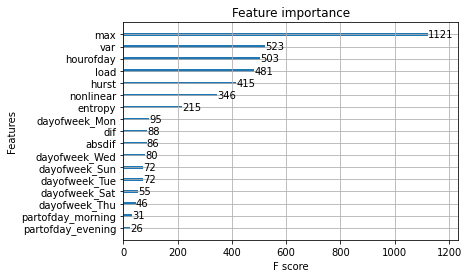

EV Features importance


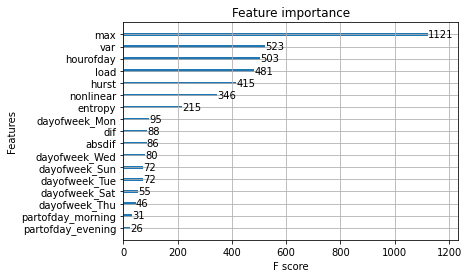

OVEN Features importance


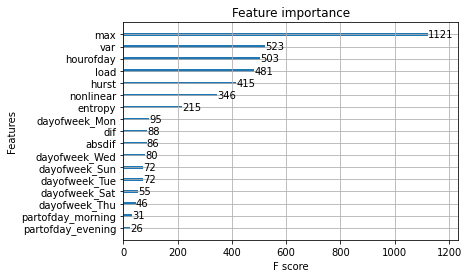

WASH Features importance


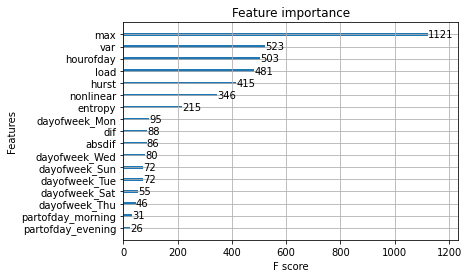

DRYER Features importance


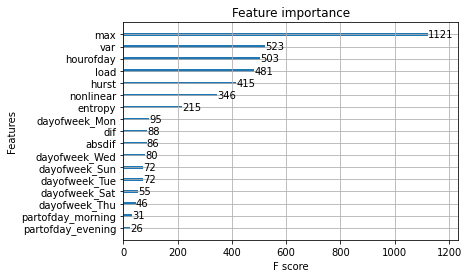

In [ ]:
# plotting the Features importance graph
# using only the best performing models so far to plot
top_models = top_n(1)
for target in targets:
    # subsetting with best- performing models of every target
    top_model_subset = top_models[(top_models.target==target)&(top_models.model=='XGBClassifier')].reset_index(drop=True)
    # getting model_id to be able to look for the trained model in the dictionary
    model_id = top_model_subset.loc[0, 'model_id']
    trained_model = trained_model_dict[model_id]
    # using the features importance plot provided by xgboost
    plot_importance(trained_model)
    print(target.upper(), 'Features importance')
    pyplot.show()

We are able to see that the non-relevant attributes repeat across all the models (we can see how the hour of the day is more important than the day of the week, as we pointed out in the Exploration). So we are going to train models removing these features one by one and see what happens:

In [ ]:
# specifying models
models = [RandomForestClassifier(), XGBClassifier(use_label_encoder=False, eval_metric = 'logloss')]
# specifying attributes to remove from the models
columns_to_remove = ['dif','absdif' ,'entropy','dayofweek', 'partofday']
# still no hyperparameter specifications
hyperparameters_to_tune = None
# doing it for every target
for target in targets:
    # for every weak attribute
    for feature_to_remove in columns_to_remove:
        # for every model (XGBoost and RF)
        for model in models:
            model_name = model_name = model.__class__.__name__
            if model_name == 'XGBClassifier':
                # loading optimal threshold for particular target of XGBoost models
                threshold = optimal_threshold_xgb[target]
            else:
                # loading optimal threshold for particular target of RF models
                threshold = optimal_threshold_rf[target]
            # training and validating each new model without the feature to see if we can further improve performance
            train_validate_models(model, train_data, target, [0], 1, [feature_to_remove], hyperparameters_to_tune, threshold)

RandomForestClassifier   Target: ac , Window_size: 0 
 Column removed: ['dif'] 
 Threshold: 0.55 , Hyperparameters Tuning: None 
 f1score:  0.988761814979285 
 recall:  0.9833703429558351 
 precision:  0.9942127319896228 
 [[63163   116]
 [  337 19928]]
XGBClassifier   Target: ac , Window_size: 0 
 Column removed: ['dif'] 
 Threshold: 0.4901 , Hyperparameters Tuning: None 
 f1score:  0.9879827901686365 
 recall:  0.9858376511226252 
 precision:  0.9901372850275065 
 [[63080   199]
 [  287 19978]]
RandomForestClassifier   Target: ac , Window_size: 0 
 Column removed: ['absdif'] 
 Threshold: 0.55 , Hyperparameters Tuning: None 
 f1score:  0.990841130749047 
 recall:  0.9876141130027141 
 precision:  0.9940893061143397 
 [[63160   119]
 [  251 20014]]
XGBClassifier   Target: ac , Window_size: 0 
 Column removed: ['absdif'] 
 Threshold: 0.4901 , Hyperparameters Tuning: None 
 f1score:  0.9911901882881327 
 recall:  0.9910189982728843 
 precision:  0.9913614374568072 
 [[63104   175]
 [  18

XGBClassifier   Target: wash , Window_size: 0 
 Column removed: ['absdif'] 
 Threshold: 0.2322 , Hyperparameters Tuning: None 
 f1score:  0.692857142857143 
 recall:  0.6915100453661698 
 precision:  0.6942094990240729 
 [[81531   470]
 [  476  1067]]
RandomForestClassifier   Target: wash , Window_size: 0 
 Column removed: ['entropy'] 
 Threshold: 0.2 , Hyperparameters Tuning: None 
 f1score:  0.7267726161369193 
 recall:  0.7705767984445885 
 precision:  0.6876807403123193 
 [[81461   540]
 [  354  1189]]
XGBClassifier   Target: wash , Window_size: 0 
 Column removed: ['entropy'] 
 Threshold: 0.2322 , Hyperparameters Tuning: None 
 f1score:  0.6874391431353457 
 recall:  0.6863253402462735 
 precision:  0.688556566970091 
 [[81522   479]
 [  484  1059]]
RandomForestClassifier   Target: wash , Window_size: 0 
 Column removed: ['dayofweek'] 
 Threshold: 0.2 , Hyperparameters Tuning: None 
 f1score:  0.6585285384361598 
 recall:  0.6467919637070642 
 precision:  0.6706989247311828 
 [[81

In [ ]:
# we see the top 3 models of each target and type of model to undestrand if we can further remove
# combination of variables
top_models = top_n(3).sort_values(by=['target', 'f1_score'], ascending = [True, False])
top_models

,target,model,model_id,window_size,f1_score,recall,precision,threshold,eliminated_feature,hyperparameter_tuning
0,ac,XGBClassifier,XGBClassifier_ac_0_no_['absdif']_None_threshol...,0.0,0.9912,0.9910,0.9914,0.4901,['absdif'],None
1,ac,XGBClassifier,XGBClassifier_ac_0_no_None_None_threshold0.5,0.0,0.9910,0.9906,0.9914,0.5000,None,None
2,ac,XGBClassifier,XGBClassifier_ac_0_no_None_None_threshold0.4901,0.0,0.9910,0.9908,0.9911,0.4901,None,None
3,ac,RandomForestClassifier,RandomForestClassifier_ac_0_no_None_None_thres...,0.0,0.9909,0.9885,0.9933,0.5500,None,None
4,ac,RandomForestClassifier,RandomForestClassifier_ac_0_no_['absdif']_None...,0.0,0.9908,0.9876,0.9941,0.5500,['absdif'],None
5,ac,RandomForestClassifier,RandomForestClassifier_ac_0_no_['entropy']_Non...,0.0,0.9907,0.9885,0.9929,0.5500,['entropy'],None
15,dryer,RandomForestClassifier,RandomForestClassifier_dryer_0_no_['absdif']_N...,0.0,0.9495,0.9518,0.9471,0.2800,['absdif'],None
16,dryer,RandomForestClassifier,RandomForestClassifier_dryer_0_no_['dif']_None...,0.0,0.9381,0.9401,0.9362,0.2800,['dif'],None
17,dryer,RandomForestClassifier,RandomForestClassifier_dryer_0_no_None_None_th...,0.0,0.9065,0.8938,0.9196,0.2800,None,None
12,dryer,XGBClassifier,XGBClassifier_dryer_0_no_['entropy']_None_thre...,0.0,0.8642,0.8502,0.8788,0.2793,['entropy'],None


In [ ]:
# trying models by eliminating combination of variables for Random Forest models:
for target in ['dryer', 'ev', 'oven', 'wash']:
    train_validate_models(RandomForestClassifier(), train_data, target, [0], 1, ['dif', 'absdif'], None, optimal_threshold_rf[target])

RandomForestClassifier   Target: dryer , Window_size: 0 
 Column removed: ['dif', 'absdif'] 
 Threshold: 0.28 , Hyperparameters Tuning: None 
 f1score:  0.9703605814612046 
 recall:  0.9749620637329287 
 precision:  0.9658023299511462 
 [[80817    91]
 [   66  2570]]
RandomForestClassifier   Target: ev , Window_size: 0 
 Column removed: ['dif', 'absdif'] 
 Threshold: 0.29 , Hyperparameters Tuning: None 
 f1score:  0.9702970297029703 
 recall:  0.962671905697446 
 precision:  0.9780439121756487 
 [[83024    11]
 [   19   490]]
RandomForestClassifier   Target: oven , Window_size: 0 
 Column removed: ['dif', 'absdif'] 
 Threshold: 0.36 , Hyperparameters Tuning: None 
 f1score:  0.9209566274827726 
 recall:  0.9117174959871589 
 precision:  0.9303849303849304 
 [[82213    85]
 [  110  1136]]
RandomForestClassifier   Target: wash , Window_size: 0 
 Column removed: ['dif', 'absdif'] 
 Threshold: 0.2 , Hyperparameters Tuning: None 
 f1score:  0.8289630512514898 
 recall:  0.9014906027219702 


In [ ]:
# trying models by eliminating combination of variables for Random XGBoost models:
train_validate_models(XGBClassifier(use_label_encoder=False, eval_metric = 'logloss'), train_data, 'dryer', [0], 1, ['entropy', 'partofday'], None, optimal_threshold_xgb['dryer'])
train_validate_models(XGBClassifier(use_label_encoder=False, eval_metric = 'logloss'), train_data, 'dryer', [0], 1, ['dif', 'entropy', 'absdif'], None, optimal_threshold_xgb['dryer'])
train_validate_models(XGBClassifier(use_label_encoder=False, eval_metric = 'logloss'), train_data, 'oven', [0], 1, ['dif', 'entropy'], None, optimal_threshold_xgb['oven'])
train_validate_models(XGBClassifier(use_label_encoder=False, eval_metric = 'logloss'), train_data, 'oven', [0], 1, ['dif', 'entropy', 'absdif'], None, optimal_threshold_xgb['oven'])
train_validate_models(XGBClassifier(use_label_encoder=False, eval_metric = 'logloss'), train_data, 'wash', [0], 1, ['dif', 'entropy', 'absdif'], None, optimal_threshold_xgb['wash'])

XGBClassifier   Target: dryer , Window_size: 0 
 Column removed: ['entropy', 'partofday'] 
 Threshold: 0.2793 , Hyperparameters Tuning: None 
 f1score:  0.8569769692277917 
 recall:  0.8399089529590288 
 precision:  0.8747530620308178 
 [[80591   317]
 [  422  2214]]
XGBClassifier   Target: dryer , Window_size: 0 
 Column removed: ['dif', 'entropy', 'absdif'] 
 Threshold: 0.2793 , Hyperparameters Tuning: None 
 f1score:  0.8650234741784039 
 recall:  0.8387708649468892 
 precision:  0.8929725363489499 
 [[80643   265]
 [  425  2211]]
XGBClassifier   Target: oven , Window_size: 0 
 Column removed: ['dif', 'entropy'] 
 Threshold: 0.3672 , Hyperparameters Tuning: None 
 f1score:  0.897631473303894 
 recall:  0.8972712680577849 
 precision:  0.8979919678714859 
 [[82171   127]
 [  128  1118]]
XGBClassifier   Target: oven , Window_size: 0 
 Column removed: ['dif', 'entropy', 'absdif'] 
 Threshold: 0.3672 , Hyperparameters Tuning: None 
 f1score:  0.8956557044254974 
 recall:  0.885232744783

In [ ]:
top_models = top_n(1).sort_values(by=['target', 'f1_score'], ascending = [True, False])
top_models

,target,model,model_id,window_size,f1_score,recall,precision,threshold,eliminated_feature,hyperparameter_tuning
0,ac,XGBClassifier,XGBClassifier_ac_0_no_['absdif']_None_threshol...,0.0,0.9912,0.9910,0.9914,0.4901,['absdif'],None
1,ac,RandomForestClassifier,RandomForestClassifier_ac_0_no_None_None_thres...,0.0,0.9909,0.9885,0.9933,0.5500,None,None
5,dryer,RandomForestClassifier,"RandomForestClassifier_dryer_0_no_['dif', 'abs...",0.0,0.9704,0.9750,0.9658,0.2800,"['dif', 'absdif']",None
4,dryer,XGBClassifier,"XGBClassifier_dryer_0_no_['dif', 'entropy', 'a...",0.0,0.8650,0.8388,0.8930,0.2793,"['dif', 'entropy', 'absdif']",None
2,ev,XGBClassifier,XGBClassifier_ev_0_no_None_None_threshold0.2009,0.0,0.9842,0.9784,0.9901,0.2009,None,None
3,ev,RandomForestClassifier,"RandomForestClassifier_ev_0_no_['dif', 'absdif...",0.0,0.9703,0.9627,0.9780,0.2900,"['dif', 'absdif']",None
7,oven,RandomForestClassifier,"RandomForestClassifier_oven_0_no_['dif', 'absd...",0.0,0.9210,0.9117,0.9304,0.3600,"['dif', 'absdif']",None
6,oven,XGBClassifier,XGBClassifier_oven_0_no_['dif']_None_threshold...,0.0,0.9065,0.9069,0.9062,0.3672,['dif'],None
9,wash,RandomForestClassifier,"RandomForestClassifier_wash_0_no_['dif', 'absd...",0.0,0.8290,0.9015,0.7672,0.2000,"['dif', 'absdif']",None
8,wash,XGBClassifier,"XGBClassifier_wash_0_no_['dif', 'entropy', 'ab...",0.0,0.7155,0.7058,0.7255,0.2322,"['dif', 'entropy', 'absdif']",None


We are able to see how in some targets the elimination of combination of features improved further the performances.

In [ ]:
# loading info of this second step into dataframe
step = 'Feature Selection'
evolution_performance(step, evolution_index)
evolution_index += 1
evolution_performance_df

,Step,Mean F1-score RF,Mean F1-score XGBoost,Mean F1-score Optimal
0,Basic Models,0.8061,0.8283,0.8310
1,Optimum Thresholds,0.8920,0.8842,0.8996
2,Feature Selection,0.9363,0.8925,0.9392


We are able to observe that the general overall performance of the models improved after this step. Moreover, the effect that this step had in the Random Forest models was considerably higher than the one it had in the XGBoost models.

### Tuning hyperparameters

Let's try now tuning the hyperparameters to see if we can improve our performance.
We are going to select the current best performing model of each target and try to tune the following hyperparameters by steps, selecting the optimal for the first ones, then fix those optimal parameters and select optimal for the following, and so on:

#### XGBoost
* max_depth and min_child_weight
* learning_rate and reg_lambda
* n_estimators

But first, let's define a few helper functions to avoid repeating code:

In [ ]:
# this function will retrieve the optimal features to remove for a specified target and
# model type, according to what we just found
def retrieve_features_to_remove(target, model_type):
    # best-performing models, ordered
    optimal_model = top_n(1)
    # subsetting by required target
    target_subset = optimal_model[(optimal_model.target==target)&(optimal_model.model==model_type)].reset_index(drop=True)
    # extracting features to remove to specify in training
    features_to_remove = target_subset.loc[0, 'eliminated_feature']
    # transforming string list of features to actual list
    if features_to_remove != 'None':
        features_to_remove = features_to_remove.strip('][').replace("'",'').split(',')
        features_to_remove = [feature.lstrip() for feature in features_to_remove]
    else:
        features_to_remove = None
    return features_to_remove

#### max_depth and min_child_weight

In [ ]:
# looping over all the targets
for target in targets:
    # retrieving features to remove for the best performing XGBoost model so far for the required target
    features_to_remove = retrieve_features_to_remove(target, 'XGBClassifier')
    # looping over the combinations of the hyperparameters to train and evaluate each one
    for max_depth in [6,8,9,10,11]:
        for min_child in range(1,4):
            hyperparameters_to_tune = {'max_depth': max_depth, 'min_child_weight' : min_child}
            model = XGBClassifier(eval_metric = 'logloss', use_label_encoder=False, max_depth = max_depth, min_child_weight = min_child)
            train_validate_models(model, train_data, target, [0], 1, features_to_remove , hyperparameters_to_tune, optimal_threshold_xgb[target])

XGBClassifier   Target: ac , Window_size: 0 
 Column removed: ['absdif'] 
 Threshold: 0.4901 , Hyperparameters Tuning: {'max_depth': 6, 'min_child_weight': 1} 
 f1score:  0.9911901882881327 
 recall:  0.9910189982728843 
 precision:  0.9913614374568072 
 [[63104   175]
 [  182 20083]]
XGBClassifier   Target: ac , Window_size: 0 
 Column removed: ['absdif'] 
 Threshold: 0.4901 , Hyperparameters Tuning: {'max_depth': 6, 'min_child_weight': 2} 
 f1score:  0.9905039094294946 
 recall:  0.9908216136195411 
 precision:  0.9901864089160667 
 [[63080   199]
 [  186 20079]]
XGBClassifier   Target: ac , Window_size: 0 
 Column removed: ['absdif'] 
 Threshold: 0.4901 , Hyperparameters Tuning: {'max_depth': 6, 'min_child_weight': 3} 
 f1score:  0.9903793971088855 
 recall:  0.9905748828028621 
 precision:  0.9901839885562078 
 [[63080   199]
 [  191 20074]]
XGBClassifier   Target: ac , Window_size: 0 
 Column removed: ['absdif'] 
 Threshold: 0.4901 , Hyperparameters Tuning: {'max_depth': 8, 'min_c

XGBClassifier   Target: ev , Window_size: 0 
 Column removed: None 
 Threshold: 0.2009 , Hyperparameters Tuning: {'max_depth': 11, 'min_child_weight': 3} 
 f1score:  0.9672943508424183 
 recall:  0.9587426326129665 
 precision:  0.976 
 [[83023    12]
 [   21   488]]
XGBClassifier   Target: oven , Window_size: 0 
 Column removed: ['dif'] 
 Threshold: 0.3672 , Hyperparameters Tuning: {'max_depth': 6, 'min_child_weight': 1} 
 f1score:  0.906538307260329 
 recall:  0.9069020866773676 
 precision:  0.9061748195669607 
 [[82181   117]
 [  116  1130]]
XGBClassifier   Target: oven , Window_size: 0 
 Column removed: ['dif'] 
 Threshold: 0.3672 , Hyperparameters Tuning: {'max_depth': 6, 'min_child_weight': 2} 
 f1score:  0.8954380298748486 
 recall:  0.8900481540930979 
 precision:  0.90089358245329 
 [[82176   122]
 [  137  1109]]
XGBClassifier   Target: oven , Window_size: 0 
 Column removed: ['dif'] 
 Threshold: 0.3672 , Hyperparameters Tuning: {'max_depth': 6, 'min_child_weight': 3} 
 f1sco

XGBClassifier   Target: wash , Window_size: 0 
 Column removed: ['dif', 'entropy', 'absdif'] 
 Threshold: 0.2322 , Hyperparameters Tuning: {'max_depth': 11, 'min_child_weight': 1} 
 f1score:  0.8160362107985775 
 recall:  0.8178872326636423 
 precision:  0.8141935483870968 
 [[81713   288]
 [  281  1262]]
XGBClassifier   Target: wash , Window_size: 0 
 Column removed: ['dif', 'entropy', 'absdif'] 
 Threshold: 0.2322 , Hyperparameters Tuning: {'max_depth': 11, 'min_child_weight': 2} 
 f1score:  0.8094932649134061 
 recall:  0.8178872326636423 
 precision:  0.8012698412698412 
 [[81688   313]
 [  281  1262]]
XGBClassifier   Target: wash , Window_size: 0 
 Column removed: ['dif', 'entropy', 'absdif'] 
 Threshold: 0.2322 , Hyperparameters Tuning: {'max_depth': 11, 'min_child_weight': 3} 
 f1score:  0.8066961465571699 
 recall:  0.8276085547634479 
 precision:  0.7868145409735059 
 [[81655   346]
 [  266  1277]]
XGBClassifier   Target: dryer , Window_size: 0 
 Column removed: ['dif', 'entro

In [ ]:
top_models = top_n(2).sort_values(by=['target', 'f1_score'], ascending = [True, False])
top_models

,target,model,model_id,window_size,f1_score,recall,precision,threshold,eliminated_feature,hyperparameter_tuning
0,ac,XGBClassifier,XGBClassifier_ac_0_no_['absdif']_{'max_depth':...,0.0,0.9915,0.9913,0.9917,0.4901,['absdif'],"{'max_depth': 10, 'min_child_weight': 1}"
1,ac,XGBClassifier,XGBClassifier_ac_0_no_['absdif']_{'max_depth':...,0.0,0.9915,0.9916,0.9915,0.4901,['absdif'],"{'max_depth': 9, 'min_child_weight': 2}"
2,ac,RandomForestClassifier,RandomForestClassifier_ac_0_no_None_None_thres...,0.0,0.9909,0.9885,0.9933,0.5500,None,None
3,ac,RandomForestClassifier,RandomForestClassifier_ac_0_no_['absdif']_None...,0.0,0.9908,0.9876,0.9941,0.5500,['absdif'],None
8,dryer,XGBClassifier,"XGBClassifier_dryer_0_no_['dif', 'entropy', 'a...",0.0,0.9710,0.9662,0.9759,0.2793,"['dif', 'entropy', 'absdif']","{'max_depth': 11, 'min_child_weight': 1}"
10,dryer,RandomForestClassifier,"RandomForestClassifier_dryer_0_no_['dif', 'abs...",0.0,0.9704,0.9750,0.9658,0.2800,"['dif', 'absdif']",None
9,dryer,XGBClassifier,"XGBClassifier_dryer_0_no_['dif', 'entropy', 'a...",0.0,0.9659,0.9624,0.9694,0.2793,"['dif', 'entropy', 'absdif']","{'max_depth': 11, 'min_child_weight': 2}"
11,dryer,RandomForestClassifier,RandomForestClassifier_dryer_0_no_['absdif']_N...,0.0,0.9495,0.9518,0.9471,0.2800,['absdif'],None
4,ev,XGBClassifier,"XGBClassifier_ev_0_no_None_{'max_depth': 6, 'm...",0.0,0.9842,0.9784,0.9901,0.2009,None,"{'max_depth': 6, 'min_child_weight': 1}"
5,ev,XGBClassifier,XGBClassifier_ev_0_no_None_None_threshold0.2009,0.0,0.9842,0.9784,0.9901,0.2009,None,None


We see how tuning these hyperparameters boosts the performance for several targets, specially for dryer (from 0.865 to 0.9710) and wash (from 0.7150 to 0.8160).

Let's now try with learning rate and lambda:

#### learning_rate and reg_lambda

In [ ]:
model_type = 'XGBClassifier' # still working with XGBoost
# optimal models data frame
optimal_model = top_n(1)
# looping over all the targets
for target in targets:
    # we again call this function but now with the possibility that the optimal models include
    # the previously tuned hyperparameters
    features_to_remove = retrieve_features_to_remove(target, 'XGBClassifier')
    # subsetting data with optimal models corresponding to target
    target_subset = optimal_model[(optimal_model.target==target)&(optimal_model.model==model_type)].reset_index(drop=True)
    # best performing model for this target
    model_id = target_subset.loc[0, 'model_id']
    # parameters we just tuned, to fix while trying to find the optimal new ones
    max_depth = trained_model_dict[model_id].get_params()['max_depth']
    min_child = trained_model_dict[model_id].get_params()['min_child_weight']
    # looping over the combinations of the hyperparameters to train and evaluate each one
    # 0.3 is the default one so we include values above and below
    for learning_rate in [0.4, 0.1, 0.01]:
        # 1 is the default value so we include values above and below
        for reg_lambda in [1e-6, 1e-2 ,2]:
            # hyperparameters so they can be printed on results and added to data frame
            hyperparameters_to_tune = {'max_depth': max_depth, 'min_child_weight' : min_child, \
                                       'learning_rate' : learning_rate, 'reg_lambda' : reg_lambda}
            # initializing model with optimal max_depth and min_child_weight fixed
            model = XGBClassifier(eval_metric = 'logloss', use_label_encoder=False, max_depth = max_depth, min_child_weight = min_child, \
                                  learning_rate = learning_rate, reg_lambda = reg_lambda)
            # training our model
            train_validate_models(model, train_data, target, [0], 1, features_to_remove , hyperparameters_to_tune, optimal_threshold_xgb[target])

XGBClassifier   Target: ac , Window_size: 0 
 Column removed: ['absdif'] 
 Threshold: 0.4901 , Hyperparameters Tuning: {'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.4, 'reg_lambda': 1e-06} 
 f1score:  0.991412920100676 
 recall:  0.9913150752528991 
 precision:  0.9915107842653373 
 [[63107   172]
 [  176 20089]]
XGBClassifier   Target: ac , Window_size: 0 
 Column removed: ['absdif'] 
 Threshold: 0.4901 , Hyperparameters Tuning: {'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.4, 'reg_lambda': 0.01} 
 f1score:  0.99106834443622 
 recall:  0.99106834443622 
 precision:  0.99106834443622 
 [[63098   181]
 [  181 20084]]
XGBClassifier   Target: ac , Window_size: 0 
 Column removed: ['absdif'] 
 Threshold: 0.4901 , Hyperparameters Tuning: {'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.4, 'reg_lambda': 2} 
 f1score:  0.9916128077359514 
 recall:  0.9918085368862571 
 precision:  0.9914171558230158 
 [[63105   174]
 [  166 20099]]
XGBClassifier   Target

XGBClassifier   Target: oven , Window_size: 0 
 Column removed: ['dif'] 
 Threshold: 0.3672 , Hyperparameters Tuning: {'max_depth': 8, 'min_child_weight': 1, 'learning_rate': 0.01, 'reg_lambda': 2} 
 f1score:  0.7219315895372234 
 recall:  0.7199036918138042 
 precision:  0.7239709443099274 
 [[81956   342]
 [  349   897]]
XGBClassifier   Target: wash , Window_size: 0 
 Column removed: ['dif', 'entropy', 'absdif'] 
 Threshold: 0.2322 , Hyperparameters Tuning: {'max_depth': 11, 'min_child_weight': 1, 'learning_rate': 0.4, 'reg_lambda': 1e-06} 
 f1score:  0.8316242143565995 
 recall:  0.814646791963707 
 precision:  0.8493243243243244 
 [[81778   223]
 [  286  1257]]
XGBClassifier   Target: wash , Window_size: 0 
 Column removed: ['dif', 'entropy', 'absdif'] 
 Threshold: 0.2322 , Hyperparameters Tuning: {'max_depth': 11, 'min_child_weight': 1, 'learning_rate': 0.4, 'reg_lambda': 0.01} 
 f1score:  0.8272458045409674 
 recall:  0.814646791963707 
 precision:  0.8402406417112299 
 [[81762  

In [ ]:
top_models = top_n(1).sort_values(by=['target', 'f1_score'], ascending = [True, False])
top_models

,target,model,model_id,window_size,f1_score,recall,precision,threshold,eliminated_feature,hyperparameter_tuning
0,ac,XGBClassifier,XGBClassifier_ac_0_no_['absdif']_{'max_depth':...,0.0,0.9916,0.9918,0.9914,0.4901,['absdif'],"{'max_depth': 10, 'min_child_weight': 1, 'lear..."
1,ac,RandomForestClassifier,RandomForestClassifier_ac_0_no_None_None_thres...,0.0,0.9909,0.9885,0.9933,0.5500,None,None
4,dryer,XGBClassifier,"XGBClassifier_dryer_0_no_['dif', 'entropy', 'a...",0.0,0.9716,0.9670,0.9763,0.2793,"['dif', 'entropy', 'absdif']","{'max_depth': 11, 'min_child_weight': 1, 'lear..."
5,dryer,RandomForestClassifier,"RandomForestClassifier_dryer_0_no_['dif', 'abs...",0.0,0.9704,0.9750,0.9658,0.2800,"['dif', 'absdif']",None
2,ev,XGBClassifier,XGBClassifier_ev_0_no_None_None_threshold0.2009,0.0,0.9842,0.9784,0.9901,0.2009,None,None
3,ev,RandomForestClassifier,"RandomForestClassifier_ev_0_no_['dif', 'absdif...",0.0,0.9703,0.9627,0.9780,0.2900,"['dif', 'absdif']",None
6,oven,XGBClassifier,XGBClassifier_oven_0_no_['dif']_{'max_depth': ...,0.0,0.9213,0.9117,0.9311,0.3672,['dif'],"{'max_depth': 8, 'min_child_weight': 1}"
7,oven,RandomForestClassifier,"RandomForestClassifier_oven_0_no_['dif', 'absd...",0.0,0.9210,0.9117,0.9304,0.3600,"['dif', 'absdif']",None
8,wash,XGBClassifier,"XGBClassifier_wash_0_no_['dif', 'entropy', 'ab...",0.0,0.8316,0.8146,0.8493,0.2322,"['dif', 'entropy', 'absdif']","{'max_depth': 11, 'min_child_weight': 1, 'lear..."
9,wash,RandomForestClassifier,"RandomForestClassifier_wash_0_no_['dif', 'absd...",0.0,0.8290,0.9015,0.7672,0.2000,"['dif', 'absdif']",None


#### n_estimators

In [ ]:
# looping over all the targets
for target in targets:
    features_to_remove = retrieve_features_to_remove(target, 'XGBClassifier')
    # subsetting data with optimal models corresponding to target
    target_subset = optimal_model[(optimal_model.target==target)&(optimal_model.model==model_type)].reset_index(drop=True)
    # best performing model for this target
    model_id = target_subset.loc[0, 'model_id']
    max_depth = trained_model_dict[model_id].get_params()['max_depth']
    min_child = trained_model_dict[model_id].get_params()['min_child_weight']
    learning_rate = trained_model_dict[model_id].get_params()['learning_rate']
    reg_lambda = trained_model_dict[model_id].get_params()['reg_lambda']
    # looping over the combinations of the hyperparameters to train and evaluate each one
    # 100 is the default one so we include values above and below
    for n_estimators in [50, 150]:
        # hyperparameters so they can be printed on results and added to data frame
        hyperparameters_to_tune = {'max_depth': max_depth, 'min_child_weight' : min_child, \
                                   'learning_rate' : learning_rate, 'reg_lambda' : reg_lambda,\
                                  'n_estimators': n_estimators}
        # initializing model with all the optimal hyperparameters fixed
        model = XGBClassifier(eval_metric = 'logloss', use_label_encoder=False, max_depth = max_depth, min_child_weight = min_child, \
                              learning_rate = learning_rate, reg_lambda = reg_lambda, n_estimators = n_estimators)
        # training our model
        train_validate_models(model, train_data, target, [0], 1, features_to_remove , hyperparameters_to_tune, optimal_threshold_xgb[target])

XGBClassifier   Target: ac , Window_size: 0 
 Column removed: ['absdif'] 
 Threshold: 0.4901 , Hyperparameters Tuning: {'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.300000012, 'reg_lambda': 1, 'n_estimators': 50} 
 f1score:  0.9913888820350861 
 recall:  0.9913644214162349 
 precision:  0.9914133438610343 
 [[63105   174]
 [  175 20090]]
XGBClassifier   Target: ac , Window_size: 0 
 Column removed: ['absdif'] 
 Threshold: 0.4901 , Hyperparameters Tuning: {'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.300000012, 'reg_lambda': 1, 'n_estimators': 150} 
 f1score:  0.9917559362195785 
 recall:  0.9913644214162349 
 precision:  0.9921477603832288 
 [[63120   159]
 [  175 20090]]
XGBClassifier   Target: ev , Window_size: 0 
 Column removed: None 
 Threshold: 0.2009 , Hyperparameters Tuning: {'max_depth': 6, 'min_child_weight': 1, 'learning_rate': 0.300000012, 'reg_lambda': 1, 'n_estimators': 50} 
 f1score:  0.9684418145956607 
 recall:  0.9646365422396856 
 precisio

#### XGBoost hyperparameters explanation

A little explanation on these hyperparameters and why we chose them:
* max_depth: maximum depth of the tree. Increasing this value makes the tree more complex and more prone to overfitting.
* min_child_weight: hyperparameter to control the growing size of a tree.  If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the algorithm will stop partitioning. Larger values of this hyperparameter are generally associated with reduction of overfitting and reduction of complexity as well.
* learning_rate: size of the step taken in the opposite direction of the gradient while updating the weights of the new features in the gradient descent optimization. Shorter steps make the model more conservative, hence, less likely to overfit.
* lambda_reg: L2 regularisation parameter. As lambda increases, the penalty imposed on the complexity of the model grows, making the model less complex and less likely to overfit.
* n_estimators: how many trees we will build in our ensemble. More trees is generally associated with reducing overfitting.

As we can see in the hyperparameters description, the main focus of them all is to address the bias-variance tradeoff is usually a big problem in Boosting Algorithms. Nevertheless, this issue can be overcame by XGBoost with the inclusion of all these alternatives, at the cost of having to know properly how to use them because there are so many (there are even more hyperparameters that have an influence on over and underfitting that we are not using).

In [ ]:
# seeing if we have reached improvements...
top_models = top_n(1).sort_values(by=['target', 'f1_score'], ascending = [True, False])
top_models

,target,model,model_id,window_size,f1_score,recall,precision,threshold,eliminated_feature,hyperparameter_tuning
0,ac,XGBClassifier,XGBClassifier_ac_0_no_['absdif']_{'max_depth':...,0.0,0.9918,0.9914,0.9921,0.4901,['absdif'],"{'max_depth': 10, 'min_child_weight': 1, 'lear..."
1,ac,RandomForestClassifier,RandomForestClassifier_ac_0_no_None_None_thres...,0.0,0.9909,0.9885,0.9933,0.5500,None,None
4,dryer,XGBClassifier,"XGBClassifier_dryer_0_no_['dif', 'entropy', 'a...",0.0,0.9729,0.9670,0.9789,0.2793,"['dif', 'entropy', 'absdif']","{'max_depth': 11, 'min_child_weight': 1, 'lear..."
5,dryer,RandomForestClassifier,"RandomForestClassifier_dryer_0_no_['dif', 'abs...",0.0,0.9704,0.9750,0.9658,0.2800,"['dif', 'absdif']",None
2,ev,XGBClassifier,"XGBClassifier_ev_0_no_None_{'max_depth': 6, 'm...",0.0,0.9852,0.9804,0.9901,0.2009,None,"{'max_depth': 6, 'min_child_weight': 1, 'learn..."
3,ev,RandomForestClassifier,"RandomForestClassifier_ev_0_no_['dif', 'absdif...",0.0,0.9703,0.9627,0.9780,0.2900,"['dif', 'absdif']",None
6,oven,XGBClassifier,XGBClassifier_oven_0_no_['dif']_{'max_depth': ...,0.0,0.9267,0.9181,0.9354,0.3672,['dif'],"{'max_depth': 8, 'min_child_weight': 1, 'learn..."
7,oven,RandomForestClassifier,"RandomForestClassifier_oven_0_no_['dif', 'absd...",0.0,0.9210,0.9117,0.9304,0.3600,"['dif', 'absdif']",None
8,wash,XGBClassifier,"XGBClassifier_wash_0_no_['dif', 'entropy', 'ab...",0.0,0.8316,0.8146,0.8493,0.2322,"['dif', 'entropy', 'absdif']","{'max_depth': 11, 'min_child_weight': 1, 'lear..."
9,wash,RandomForestClassifier,"RandomForestClassifier_wash_0_no_['dif', 'absd...",0.0,0.8290,0.9015,0.7672,0.2000,"['dif', 'absdif']",None


#### Random Forest

For Random Forest we are going to try them all at once because we are only working with 2 because of computational constraints (Random Forest is considerably slower than XGBoost):
 * n_estimators and max_depth.

In [ ]:
for target in targets:
    # retrieving features to remove for the best performing RF model so far for the required target
    features_to_remove = retrieve_features_to_remove(target, 'RandomForestClassifier')
    for max_depth in [50, 100]:
        for n_estimators in [200, 500]:
                hyperparameters_to_tune = {'max_depth': max_depth, 'n_estimators': n_estimators}
                model = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators)
                train_validate_models(model, train_data, target, [0], 1, features_to_remove , hyperparameters_to_tune, optimal_threshold_rf[target])

RandomForestClassifier   Target: ac , Window_size: 0 
 Column removed: None 
 Threshold: 0.55 , Hyperparameters Tuning: {'max_depth': 50, 'n_estimators': 200} 
 f1score:  0.9906509695290858 
 recall:  0.9882556131260795 
 precision:  0.9930579659840333 
 [[63139   140]
 [  238 20027]]
RandomForestClassifier   Target: ac , Window_size: 0 
 Column removed: None 
 Threshold: 0.55 , Hyperparameters Tuning: {'max_depth': 50, 'n_estimators': 500} 
 f1score:  0.9906999752658916 
 recall:  0.9882556131260795 
 precision:  0.9931564592115051 
 [[63141   138]
 [  238 20027]]
RandomForestClassifier   Target: ac , Window_size: 0 
 Column removed: None 
 Threshold: 0.55 , Hyperparameters Tuning: {'max_depth': 100, 'n_estimators': 200} 
 f1score:  0.9906505070492209 
 recall:  0.9882062669627436 
 precision:  0.9931068683362262 
 [[63140   139]
 [  239 20026]]
RandomForestClassifier   Target: ac , Window_size: 0 
 Column removed: None 
 Threshold: 0.55 , Hyperparameters Tuning: {'max_depth': 100, 'n

#### Random Forest hyperparameters explanation

A little explanation on these hyperparameters:

* max_depth: same concept as in XGBoost, referring to the depth of the tree. In Random Forest this number is usually considerably larger than in XGBoost because RF, being a Bagging algorithm, is looking for minimizing the variance. As pointed out above, for larger values of max_depth our model becomes more complex.
* n_estimators: number of trees that are being built in parallel to achieve the final prediction. With more estimators, our model will be less prone to overfitting. 

Our intention at first was to also include a minimum number of features and minimum number of samples left in the final node, which are hyperparameters that can also help contain overfitting (we actually used a low value for these 2, as recommended to control complexity and avoid overfitting), but we were not able because of computational constraints.


In [ ]:
# taking a look at the top performing models so far
top_models = top_n(1).sort_values(by=['target', 'f1_score'], ascending = [True, False])
top_models

,target,model,model_id,window_size,f1_score,recall,precision,threshold,eliminated_feature,hyperparameter_tuning
0,ac,XGBClassifier,XGBClassifier_ac_0_no_['absdif']_{'max_depth':...,0.0,0.9918,0.9914,0.9921,0.4901,['absdif'],"{'max_depth': 10, 'min_child_weight': 1, 'lear..."
1,ac,RandomForestClassifier,RandomForestClassifier_ac_0_no_None_None_thres...,0.0,0.9909,0.9885,0.9933,0.5500,None,None
4,dryer,XGBClassifier,"XGBClassifier_dryer_0_no_['dif', 'entropy', 'a...",0.0,0.9729,0.9670,0.9789,0.2793,"['dif', 'entropy', 'absdif']","{'max_depth': 11, 'min_child_weight': 1, 'lear..."
5,dryer,RandomForestClassifier,"RandomForestClassifier_dryer_0_no_['dif', 'abs...",0.0,0.9718,0.9753,0.9684,0.2800,"['dif', 'absdif']","{'max_depth': 100, 'n_estimators': 500}"
2,ev,XGBClassifier,"XGBClassifier_ev_0_no_None_{'max_depth': 6, 'm...",0.0,0.9852,0.9804,0.9901,0.2009,None,"{'max_depth': 6, 'min_child_weight': 1, 'learn..."
3,ev,RandomForestClassifier,"RandomForestClassifier_ev_0_no_['dif', 'absdif...",0.0,0.9722,0.9607,0.9839,0.2900,"['dif', 'absdif']","{'max_depth': 100, 'n_estimators': 500}"
6,oven,XGBClassifier,XGBClassifier_oven_0_no_['dif']_{'max_depth': ...,0.0,0.9267,0.9181,0.9354,0.3672,['dif'],"{'max_depth': 8, 'min_child_weight': 1, 'learn..."
7,oven,RandomForestClassifier,"RandomForestClassifier_oven_0_no_['dif', 'absd...",0.0,0.9210,0.9117,0.9304,0.3600,"['dif', 'absdif']",None
8,wash,XGBClassifier,"XGBClassifier_wash_0_no_['dif', 'entropy', 'ab...",0.0,0.8316,0.8146,0.8493,0.2322,"['dif', 'entropy', 'absdif']","{'max_depth': 11, 'min_child_weight': 1, 'lear..."
9,wash,RandomForestClassifier,"RandomForestClassifier_wash_0_no_['dif', 'absd...",0.0,0.8315,0.9054,0.7688,0.2000,"['dif', 'absdif']","{'max_depth': 100, 'n_estimators': 200}"


In [ ]:
# loading info of this second step into dataframe
step = 'Hyperparameter tuning'
evolution_performance(step, evolution_index)
evolution_index += 1
evolution_performance_df

,Step,Mean F1-score RF,Mean F1-score XGBoost,Mean F1-score Optimal
0,Basic Models,0.8061,0.8283,0.8310
1,Optimum Thresholds,0.8920,0.8842,0.8996
2,Feature Selection,0.9363,0.8925,0.9392
3,Hyperparameter tuning,0.9375,0.9416,0.9416


As we are able to observe in the above table, the increase in the overall performance for XGBoost models was considerably larger than the one in Random Forest. This is due in part to us being able to explore more hyperparameters with XGBoost because of the speed of the algorithm. It was simply impossible to have done the same thing with Random Forest that takes a lot of time to run.

### Window size tuning

Here we are going to see if training our data including instances within a neighborhood (n previous and n posterior instances) has any effect on our performance. The values that we decided to try in each target are related to the average usage time we found during exploration. We are going to first retrieve the best performing models so far of each target and each model type (by creating the following function to avoid repeating code):

In [ ]:
def retrieve_model(target, model_type):
    # optimal models
    performance_optim = top_n(1)
    # subsetting by target
    target_subset = performance_optim[(performance_optim.target==target)&(performance_optim.model==model_type)].reset_index(drop=True)
    # retrieving parameters of best-performing model of particular target and particular model_type
    params = trained_model_dict[target_subset.loc[0,'model_id']].get_params()
    # initializing an instance of the model with all the optimal hyperparameters
    if model_type == 'XGBClassifier':
        model =XGBClassifier(**params)
    else:
        model = RandomForestClassifier(**params)
    # retrieving model and parameters
    return model, params

And now we will train our best-performing models with the given values for the windows (for each target and type of models, being XGBoost and Random Forest):

In [ ]:
windows_dict = dict()
# storing possible values of windows in dict to be able to iterate them more easily
# the values for the windows are directly related to the ones we found during exploration, 
# about the average of length each appliance was being kept on once switched on.

windows_dict['ac'] = [10, 15]
windows_dict['oven'] = [4, 10]
windows_dict['wash'] = [1, 3]
windows_dict['ev'] = [35]
windows_dict['dryer'] = [10, 20]

# looping over targets and the corresponding list of possible windows (the actual iteration of the list
# of windows is directly performed in the train_evaluate function)
for target, windows in windows_dict.items():
    for model_type in ['XGBClassifier', 'RandomForestClassifier']:
        # calling above function to retrieve features to remove
        features_to_remove = retrieve_features_to_remove(target, model_type)
        # calling the above function to retrieve model and params
        model, hyperparameters = retrieve_model(target, model_type)
        if model_type=='XGBClassifier':
            # optimal threshold for XGBoost for target
            threshold = optimal_threshold_xgb[target]
        else:
            # optimal threshold for RF for target
            threshold = optimal_threshold_rf[target]
        # training best- performing model with the given set of windows
        train_validate_models(model, train_data, target, windows, 1, features_to_remove , hyperparameters, threshold)

/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: ac , Window_size: 5 
 Column removed: ['absdif'] 
 Threshold: 0.4901 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9970781954142525 
 recall:  0.9980667228473703 
 precision:  0.9960916242022461 
 [[63290    79]
 [   39 20134]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: ac , Window_size: 10 
 Column removed: ['absdif'] 
 Threshold: 0.4901 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9971096850046539 
 recall:  0.9979407727005295 
 precision:  0.9962799804209496 
 [[63068    76]
 [   42 20354]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: ac , Window_size: 15 
 Column removed: ['absdif'] 
 Threshold: 0.4901 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9970423602454108 
 recall:  0.9974568396341762 
 precision:  0.9966282251759186 
 [[63022    69]
 [   52 20395]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForestClassifier   Target: ac , Window_size: 5 
 Column removed: None 
 Threshold: 0.55 , Hyperparameters Tuning: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
 f1score:  0.9955910036659072 
 recall:  0.9962325881128241 
 precision:  0.9949502450616368 
 [[63267   102]
 [   76 20097]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForestClassifier   Target: ac , Window_size: 10 
 Column removed: None 
 Threshold: 0.55 , Hyperparameters Tuning: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
 f1score:  0.9964222701431091 
 recall:  0.9968131006079624 
 precision:  0.996031746031746 
 [[63063    81]
 [   65 20331]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForestClassifier   Target: ac , Window_size: 15 
 Column removed: None 
 Threshold: 0.55 , Hyperparameters Tuning: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
 f1score:  0.9960143775827077 
 recall:  0.9960874455910402 
 precision:  0.9959413202933985 
 [[63008    83]
 [   80 20367]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: oven , Window_size: 4 
 Column removed: ['dif'] 
 Threshold: 0.3672 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9356044869131699 
 recall:  0.9359933499584372 
 precision:  0.9352159468438538 
 [[82262    78]
 [   77  1126]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: oven , Window_size: 10 
 Column removed: ['dif'] 
 Threshold: 0.3672 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9438669438669439 
 recall:  0.9395695364238411 
 precision:  0.948203842940685 
 [[82270    62]
 [   73  1135]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: oven , Window_size: 12 
 Column removed: ['dif'] 
 Threshold: 0.3672 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9383765405864852 
 recall:  0.9403747870528109 
 precision:  0.9363867684478372 
 [[82291    75]
 [   70  1104]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForestClassifier   Target: oven , Window_size: 4 
 Column removed: ['dif', 'absdif'] 
 Threshold: 0.36 , Hyperparameters Tuning: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
 f1score:  0.88915857605178 
 recall:  0.913549459684123 
 precision:  0.8660362490149724 
 [[82170   170]
 [  104  1099]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForestClassifier   Target: oven , Window_size: 10 
 Column removed: ['dif', 'absdif'] 
 Threshold: 0.36 , Hyperparameters Tuning: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
 f1score:  0.9036918138041734 
 recall:  0.9321192052980133 
 precision:  0.8769470404984424 
 [[82174   158]
 [   82  1126]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForestClassifier   Target: oven , Window_size: 12 
 Column removed: ['dif', 'absdif'] 
 Threshold: 0.36 , Hyperparameters Tuning: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
 f1score:  0.8926507018992569 
 recall:  0.9207836456558773 
 precision:  0.8661858974358975 
 [[82199   167]
 [   93  1081]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: wash , Window_size: 1 
 Column removed: ['dif', 'entropy', 'absdif'] 
 Threshold: 0.2322 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.4, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1e-06, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.8030707610146862 
 recall:  0.7786407766990291 
 precision:  0.8290833907649897 
 [[81751   248]
 [  342  1203]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: wash , Window_size: 3 
 Column removed: ['dif', 'entropy', 'absdif'] 
 Threshold: 0.2322 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.4, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1e-06, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.8171466845277964 
 recall:  0.7901554404145078 
 precision:  0.8460471567267683 
 [[81777   222]
 [  324  1220]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: wash , Window_size: 6 
 Column removed: ['dif', 'entropy', 'absdif'] 
 Threshold: 0.2322 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.4, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1e-06, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.8250847457627118 
 recall:  0.7831402831402832 
 precision:  0.8717765042979942 
 [[81809   179]
 [  337  1217]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForestClassifier   Target: wash , Window_size: 1 
 Column removed: ['dif', 'absdif'] 
 Threshold: 0.2 , Hyperparameters Tuning: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
 f1score:  0.8047882136279926 
 recall:  0.8485436893203884 
 precision:  0.7653239929947461 
 [[81597   402]
 [  234  1311]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForestClassifier   Target: wash , Window_size: 3 
 Column removed: ['dif', 'absdif'] 
 Threshold: 0.2 , Hyperparameters Tuning: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
 f1score:  0.7954471544715447 
 recall:  0.792098445595855 
 precision:  0.798824297844546 
 [[81691   308]
 [  321  1223]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForestClassifier   Target: wash , Window_size: 6 
 Column removed: ['dif', 'absdif'] 
 Threshold: 0.2 , Hyperparameters Tuning: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
 f1score:  0.7797062750333777 
 recall:  0.7516087516087516 
 precision:  0.8099861303744799 
 [[81714   274]
 [  386  1168]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: ev , Window_size: 35 
 Column removed: None 
 Threshold: 0.2009 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.99457111834962 
 recall:  0.9892008639308856 
 precision:  1.0 
 [[83067     0]
 [    5   458]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: ev , Window_size: 40 
 Column removed: None 
 Threshold: 0.2009 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9873684210526317 
 recall:  0.9770833333333333 
 precision:  0.997872340425532 
 [[83047     1]
 [   11   469]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: ev , Window_size: 45 
 Column removed: None 
 Threshold: 0.2009 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9790356394129979 
 recall:  0.9609053497942387 
 precision:  0.9978632478632479 
 [[83039     1]
 [   19   467]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForestClassifier   Target: ev , Window_size: 35 
 Column removed: ['dif', 'absdif'] 
 Threshold: 0.29 , Hyperparameters Tuning: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
 f1score:  0.9769484083424808 
 recall:  0.9611231101511879 
 precision:  0.9933035714285714 
 [[83064     3]
 [   18   445]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForestClassifier   Target: ev , Window_size: 40 
 Column removed: ['dif', 'absdif'] 
 Threshold: 0.29 , Hyperparameters Tuning: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
 f1score:  0.9778714436248682 
 recall:  0.9666666666666667 
 precision:  0.9893390191897654 
 [[83043     5]
 [   16   464]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForestClassifier   Target: ev , Window_size: 45 
 Column removed: ['dif', 'absdif'] 
 Threshold: 0.29 , Hyperparameters Tuning: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
 f1score:  0.9717868338557994 
 recall:  0.9567901234567902 
 precision:  0.9872611464968153 
 [[83034     6]
 [   21   465]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: dryer , Window_size: 10 
 Column removed: ['dif', 'entropy', 'absdif'] 
 Threshold: 0.2793 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9743687108410859 
 recall:  0.9653875094055681 
 precision:  0.983518589497892 
 [[80839    43]
 [   92  2566]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: dryer , Window_size: 20 
 Column removed: ['dif', 'entropy', 'absdif'] 
 Threshold: 0.2793 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9773689052437903 
 recall:  0.967930029154519 
 precision:  0.9869936826458565 
 [[80757    35]
 [   88  2656]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForestClassifier   Target: dryer , Window_size: 10 
 Column removed: ['dif', 'absdif'] 
 Threshold: 0.28 , Hyperparameters Tuning: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
 f1score:  0.9376470588235295 
 recall:  0.899548532731377 
 precision:  0.9791154791154791 
 [[80831    51]
 [  267  2391]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForestClassifier   Target: dryer , Window_size: 20 
 Column removed: ['dif', 'absdif'] 
 Threshold: 0.28 , Hyperparameters Tuning: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
 f1score:  0.9316484778862723 
 recall:  0.8866618075801749 
 precision:  0.9814441306978621 
 [[80746    46]
 [  311  2433]]


In [ ]:
top_models = top_n(1).sort_values(by=['target', 'f1_score'], ascending = [True, False])
top_models

,target,model,model_id,window_size,f1_score,recall,precision,threshold,eliminated_feature,hyperparameter_tuning
0,ac,XGBClassifier,XGBClassifier_ac_10_no_['absdif']_{'objective'...,10.0,0.9971,0.9979,0.9963,0.4901,['absdif'],"{'objective': 'binary:logistic', 'use_label_en..."
1,ac,RandomForestClassifier,RandomForestClassifier_ac_10_no_None_{'bootstr...,10.0,0.9964,0.9968,0.9960,0.5500,None,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
4,dryer,XGBClassifier,"XGBClassifier_dryer_20_no_['dif', 'entropy', '...",20.0,0.9774,0.9679,0.9870,0.2793,"['dif', 'entropy', 'absdif']","{'objective': 'binary:logistic', 'use_label_en..."
5,dryer,RandomForestClassifier,"RandomForestClassifier_dryer_0_no_['dif', 'abs...",0.0,0.9718,0.9753,0.9684,0.2800,"['dif', 'absdif']","{'max_depth': 100, 'n_estimators': 500}"
2,ev,XGBClassifier,XGBClassifier_ev_35_no_None_{'objective': 'bin...,35.0,0.9946,0.9892,1.0000,0.2009,None,"{'objective': 'binary:logistic', 'use_label_en..."
3,ev,RandomForestClassifier,"RandomForestClassifier_ev_40_no_['dif', 'absdi...",40.0,0.9779,0.9667,0.9893,0.2900,"['dif', 'absdif']","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
6,oven,XGBClassifier,XGBClassifier_oven_10_no_['dif']_{'objective':...,10.0,0.9439,0.9396,0.9482,0.3672,['dif'],"{'objective': 'binary:logistic', 'use_label_en..."
7,oven,RandomForestClassifier,"RandomForestClassifier_oven_0_no_['dif', 'absd...",0.0,0.9210,0.9117,0.9304,0.3600,"['dif', 'absdif']",None
8,wash,XGBClassifier,"XGBClassifier_wash_0_no_['dif', 'entropy', 'ab...",0.0,0.8316,0.8146,0.8493,0.2322,"['dif', 'entropy', 'absdif']","{'max_depth': 11, 'min_child_weight': 1, 'lear..."
9,wash,RandomForestClassifier,"RandomForestClassifier_wash_0_no_['dif', 'absd...",0.0,0.8315,0.9054,0.7688,0.2000,"['dif', 'absdif']","{'max_depth': 100, 'n_estimators': 200}"


We can see how some of the targets performances increased by including windows.

In [ ]:
# loading info of this second step into dataframe
step = 'Window size tuning'
evolution_performance(step, evolution_index)
evolution_index += 1
evolution_performance_df

,Step,Mean F1-score RF,Mean F1-score XGBoost,Mean F1-score Optimal
0,Basic Models,0.8061,0.8283,0.8310
1,Optimum Thresholds,0.8920,0.8842,0.8996
2,Feature Selection,0.9363,0.8925,0.9392
3,Hyperparameter tuning,0.9375,0.9416,0.9416
4,Window size tuning,0.9397,0.9489,0.9489


Both types of models increased their overall performances after tuning the window sizes (not as considerably but still), leading also to an increase in the general performance.

### Training models using complete data

In [ ]:
# defining function to train models
def train_model_complete(model, train_data, target, window, features_to_remove):
    if window !=0:
        windows_data_df = window_loads(window, train_data)
        train = windows_data_df
    else:
        train = train_data
    if features_to_remove != None:
        x_features = list(train.iloc[:, np.r_[1,7:len(train.columns)]].columns)
        for feature_to_remove in features_to_remove:
            x_features.remove(feature_to_remove)
        x_train = train.loc[:, x_features]
        if 'partofday' not in features_to_remove and 'dayofweek' not in features_to_remove:
            x_train = pd.get_dummies(x_train, columns=['dayofweek', 'partofday'], drop_first=True)
        elif 'dayofweek' not in features_to_remove and 'partofday' in features_to_remove:
            x_train = pd.get_dummies(x_train, columns=['dayofweek'], drop_first=True)
        elif 'dayofweek' in features_to_remove and 'partofday' not in features_to_remove:
            x_train = pd.get_dummies(x_train, columns=['partofday'], drop_first=True)  
    # transforming dayofweek into numerical variable
    else:
        x_train = train.iloc[:, np.r_[1,7:len(train.columns)]]
        # x_train = train.iloc[:, 1:]
        x_train = pd.get_dummies(x_train, columns=['dayofweek', 'partofday'], drop_first=True)
    ytrain = train[target]
    model.fit(x_train, ytrain)
    print('Training', target.upper(), 'complete!')
    return model

In [ ]:
# defining a function to retrieve the optimal settings of the best-performing model
# of a particular target, to avoid repeating code
def retrieve_optimal_settings(target):
    optimum_models_df = top_n_target(1)
    target_subset = optimum_models_df[(optimum_models_df.target==target)].reset_index(drop=True)
    window = int(target_subset.loc[0, 'window_size'])
    model_type = target_subset.loc[0, 'model']
    features_to_remove = retrieve_features_to_remove(target, model_type)
    model, params = retrieve_model(target, model_type)
    return model_type, model, params, features_to_remove, window

In [ ]:
# similar than previous function but having the possibility of specifying the
# model_type for which we want to retrieve the optimal settings
def retrieve_optimal_settings_model_type(target, model_type):
    optimum_models_df = top_n(1)
    target_subset = optimum_models_df[(optimum_models_df.target==target)&(optimum_models_df.model==model_type)].reset_index(drop=True)
    window = int(target_subset.loc[0, 'window_size'])
    model_type = target_subset.loc[0, 'model']
    features_to_remove = retrieve_features_to_remove(target, model_type)
    model, params = retrieve_model(target, model_type)
    return model, params, features_to_remove, window

We are going to train the models using the settings of the ones that yielded the best validation performance for each target. If we take a look at the top performances data frame, we can see that the best-performing models for all the appliances are XGBoost. Nevertheless, for wash and dryer the performances of RandomForest are really similar. That is why we will try 2 configurations, upload them to Kaggle and keep the one with the highest score.

* Configuration 1: XGBoost for all the appliances.
* Configuration 2: XGBoost for ac, ev and oven; Random Forest for wash and dryer.

### Configuration 1

In [ ]:
# dict where we will store the final trained models for each target
final_models_dict = dict()
# we use the best-performing model for each target to train it with the whole data
# building one model per target
for target in ['ac', 'ev', 'oven', 'wash', 'dryer']:
    model_type, model, params, features_to_remove, window = retrieve_optimal_settings(target)
    model = train_model_complete(model, train_data, target, window, features_to_remove)
    # saving all into dictionary to re-use it when making predictions
    final_models_dict[target] = [model, features_to_remove, window, model_type]

/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training AC complete!
Training EV complete!
Training OVEN complete!
Training WASH complete!
Training DRYER complete!


In [ ]:
# function that returns prediction probabilities for each target in the test set
def predict_test(model, test_data, window, features_to_remove):
    # dealing with windows as we did in the train_validate function
    if window !=0:
        windows_data_df = window_loads(window, test_data)
        test = windows_data_df
    else:
        test = test_data
    # dealing with features removal and categorical variables
    if features_to_remove != None:
        x_features = list(test.iloc[:, np.r_[1:len(test.columns)]].columns)
        for feature_to_remove in features_to_remove:
            x_features.remove(feature_to_remove)
        x_test = test.loc[:, x_features]
        if 'partofday' not in features_to_remove and 'dayofweek' not in features_to_remove:
            x_test = pd.get_dummies(x_test, columns=['dayofweek', 'partofday'], drop_first=True)
        elif 'dayofweek' not in features_to_remove and 'partofday' in features_to_remove:
            x_test = pd.get_dummies(x_test, columns=['dayofweek'], drop_first=True)
        elif 'dayofweek' in features_to_remove and 'partofday' not in features_to_remove:
            x_test = pd.get_dummies(x_test, columns=['partofday'], drop_first=True)  
    else:
        x_test = test.iloc[:, np.r_[1:len(test.columns)]]
        x_test = pd.get_dummies(x_test, columns=['dayofweek', 'partofday'], drop_first=True)
    predictions = model.predict_proba(x_test)
    # we will return probabilities, to be able to apply the threshold in the following step
    return predictions

In [ ]:
# loading test set
test_data = pd.read_csv('test_data_nolabels.csv')
# changing column name to fit specifications
test_data = test_data.rename(columns = {'Unnamed: 0':'id'})
# creating new column with part of the day as we did during training
test_data.loc[(test_data.hourofday>=0) & (test_data.hourofday<=6), 'partofday'] = 'early morning'
test_data.loc[(test_data.hourofday>6) & (test_data.hourofday<=11), 'partofday'] = 'morning'
test_data.loc[(test_data.hourofday>11) & (test_data.hourofday<=15), 'partofday'] = 'afternoon'
test_data.loc[(test_data.hourofday>15) & (test_data.hourofday<=20), 'partofday'] = 'evening'
test_data.loc[(test_data.hourofday>20) & (test_data.hourofday<=23), 'partofday'] = 'night'

In [ ]:
# defining a function that will use the above predict_test function and finally
# return a data frame with the required format for the predictions
def final_predictions():
    targets = ['ac', 'ev', 'oven', 'wash', 'dryer']
    for target in targets:
        # we retrieve the model, features, window and model_type from the dictionary created 
        # while training the final models
        model = final_models_dict[target][0]
        features_to_remove = final_models_dict[target][1]
        # features_to_remove = None
        window = final_models_dict[target][2]
        model_type = final_models_dict[target][3]
        # defining optimal threshold according to calculations we made at the beginning
        if model_type == 'XGBClassifier':
            threshold = optimal_threshold_xgb[target]
        else:
            threshold = optimal_threshold_rf[target]
        # both class probabilities
        y_prob = predict_test(model, test_data, window, features_to_remove)
        # keeping only positive probs
        positive_probs = [y_prob[i][1] for i in range(len(y_prob))]
        # making predictions using the thresholds
        predictions = (np.array(positive_probs) >= threshold).astype(int)
        # storing results in data frame
        predictions_df['id'] = test_data['id']
        # if we are using windows, we won't be able to make predictions for the first and last instances,
        # that's why we predict them as 0
        if window != 0:
            predictions_df.loc[0:(window-1), target] = 0
            predictions_df.loc[(window):(len(test_data)-window-1), target] = predictions.astype(int)              
            predictions_df.loc[(len(test_data)-window):len(test_data), target] = 0
        else:
            predictions_df[target] = predictions.astype(int)
        predictions_df[target] = predictions_df[target].astype(int)

In [ ]:
# Making use of the above function and storing result in data frame:
predictions_df = pd.DataFrame()
final_predictions()
# exporting results of Configuration 1 to csv to be able to upload to Kaggle
# here we would export the file, but we added it as a comment because it's not going to be
# the final file submission, in order not to create multiple output files
# predictions_df.to_csv('FIT5149_Ass2_output01.csv', index=False)

/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Configuration 2

And, as stated before, I will try the same configuration but changing the dryer and wash models from XGBoost to the Random Forest best-performing ones, because their performances were so similar.

In [ ]:
# Training only the best Random Forest model for wash and dryer, that will be stored into the final_models dict.
# No need to re-train all the others because they remain unchanged (as the best XGBoost versions).
targets = ['wash', 'dryer']
for target in targets:
    model_type = 'RandomForestClassifier'
    model, params, features_to_remove, window = retrieve_optimal_settings_model_type(target, model_type)
    model = train_model_complete(model, train_data, target, window, features_to_remove)
    # saving all into dictionary to re-use it when making predictions
    final_models_dict[target] = [model, features_to_remove, window, model_type]

Training WASH complete!
Training DRYER complete!


In [ ]:
# after having re-trained wash and dryer models, we make predictions again with the trained
# models that are stored in the final_models_dict dictionary
# Making use of the above function that directly stores results in data frame
predictions_df = pd.DataFrame()
final_predictions()
# here we would export the file, but we added it as a comment because it's not going to be
# the final file submission, in order not to create multiple output files
# predictions_df.to_csv('FIT5149_Ass2_output02.csv', index=False)

/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


After submitting both results to Kaggle, the one with the Random Forest model for dryer and wash yielded better results, so we are going to stick with that one. Our final configuration is then:

* XGBoost for ac, ev and oven
* Random Forest for wash and dryer

###  Checking final predictions

Now let's check if the proportions of predicted classes for each target are overall congruent when compared with the proportions in the training set (we know that the proportions can be different because it is not the same data but just to have a general idea):

In [ ]:
targets = ['ac', 'ev', 'oven', 'wash', 'dryer']
for target in targets:
    print('The proportion of positive', target.upper(), 'in the test set is', round(predictions_df[target].sum()/len(predictions_df), 4),\
          'while in the train set is', round(train_data[target].sum()/len(train_data), 4))

The proportion of positive AC in the test set is 0.085 while in the train set is 0.2423
The proportion of positive EV in the test set is 0.0016 while in the train set is 0.0056
The proportion of positive OVEN in the test set is 0.0167 while in the train set is 0.0143
The proportion of positive WASH in the test set is 0.0237 while in the train set is 0.019
The proportion of positive DRYER in the test set is 0.0282 while in the train set is 0.0325


### Recalculating thresholds using AUC curve approach

I am a little worried about the first 2: ac and ev. The proportions are considerably smaller in our predictions. Particularly with ev, our model could be biased towards the negative prediction because it is the most imbalanced class. 

Let's then try to re-calculate new optimal thresholds for all the optimal models for each target trying to maximize the auc score (instead of the f1-score as we did previously). This approach usually yields a much smaller threshold that could help overcome even more the imbalance in the classes while predicting, but generally at the cost of dropping our F1-score, which we don't want because our ultimate goal is to maximize it. Let's then analyze this trade-off for every model (and see if this can be helpful at least for ac and ev):

In [ ]:
# this chunk of code will first retrieve the predictions made by the optimal models, printing the results and 
# then it will calculate the new threshold using the auc approach. The model will be re-trained using that
# threshold and the performances will be printed as well, to be able to compare.

# dictionaries to store the optimal tresholds for each target, one per each type of model
threshold_auc_dict = dict()
predictions_xgb = dict()
predictions_rf = dict()

# looping over the targets
for target in targets:
    # using pre-defined function to retrieve the setting for the optimal models for each target
    model_type, model, params, features_to_remove, window = retrieve_optimal_settings(target)
    # optimal threshold depending on type of model and target
    if model_name == 'XGBClassifier':
        optimal_threshold = optimal_threshold_xgb[target]
    else:
        optimal_threshold = optimal_threshold_rf[target]

    train_validate_models(model, train_data, target, [window], 1, features_to_remove, \
                                    params, optimal_threshold)
    if model_type == 'XGBClassifier':
        predictions_dict = predictions_xgb
    else:
        predictions_dict = predictions_rf
    # loading predictions from corresponding dictionary (which were stored during the previous training)
    # as positive class probabilities and true labels
    predictions = predictions_dict[target]
    # sklearn function to calculate the values of false positive rate, 
    # true positive rate for different thresholds
    fpr, tpr, thresholds = roc_curve(predictions_dict[target][0], predictions_dict[target][1])
    # we calculate gmean with the following formula, we want the threshold that maximizes it
    gmean = np.sqrt(tpr * (1 - fpr))
    # index of optimal threshold
    index = np.argmax(gmean)
    optimal_threshold = round(thresholds[index], 4)
    # we store the threshold in dictionary for further use
    threshold_auc_dict[target] = optimal_threshold
    # we train and evaluate each model with the new threshold to compare
    print('OPTIMAL THRESHOLD WITH AUC CURVE APPROACH IS', optimal_threshold)
    print('EVALUATING WITH NEW THRESHOLD')
    train_validate_models(model, train_data, target, [window], 1, features_to_remove, \
                                        params, optimal_threshold)

/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: ac , Window_size: 10 
 Column removed: ['absdif'] 
 Threshold: 0.4901 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9971096850046539 
 recall:  0.9979407727005295 
 precision:  0.9962799804209496 
 [[63068    76]
 [   42 20354]]
OPTIMAL THRESHOLD WITH AUC CURVE APPROACH IS 0.2941
EVALUATING WITH NEW THRESHOLD


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: ac , Window_size: 10 
 Column removed: ['absdif'] 
 Threshold: 0.2941 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9968182485682119 
 recall:  0.9984310649146891 
 precision:  0.9952106343465937 
 [[63046    98]
 [   32 20364]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: ev , Window_size: 35 
 Column removed: None 
 Threshold: 0.2009 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.99457111834962 
 recall:  0.9892008639308856 
 precision:  1.0 
 [[83067     0]
 [    5   458]]
OPTIMAL THRESHOLD WITH AUC CURVE APPROACH IS 0.044
EVALUATING WITH NEW THRESHOLD


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: ev , Window_size: 35 
 Column removed: None 
 Threshold: 0.044 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9946062567421791 
 recall:  0.9956803455723542 
 precision:  0.9935344827586207 
 [[83064     3]
 [    2   461]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: oven , Window_size: 10 
 Column removed: ['dif'] 
 Threshold: 0.3672 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9438669438669439 
 recall:  0.9395695364238411 
 precision:  0.948203842940685 
 [[82270    62]
 [   73  1135]]
OPTIMAL THRESHOLD WITH AUC CURVE APPROACH IS 0.0127
EVALUATING WITH NEW THRESHOLD


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: oven , Window_size: 10 
 Column removed: ['dif'] 
 Threshold: 0.0127 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.8580622095101895 
 recall:  0.9933774834437086 
 precision:  0.7551919446192574 
 [[81943   389]
 [    8  1200]]
XGBClassifier   Target: wash , Window_size: 0 
 Column removed: ['dif', 'entropy', 'absdif'] 
 Threshold: 0.2322 , Hype

/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: dryer , Window_size: 20 
 Column removed: ['dif', 'entropy', 'absdif'] 
 Threshold: 0.2793 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9773689052437903 
 recall:  0.967930029154519 
 precision:  0.9869936826458565 
 [[80757    35]
 [   88  2656]]
OPTIMAL THRESHOLD WITH AUC CURVE APPROACH IS 0.0278
EVALUATING WITH NEW THRESHOLD


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: dryer , Window_size: 20 
 Column removed: ['dif', 'entropy', 'absdif'] 
 Threshold: 0.0278 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9483927019982624 
 recall:  0.994533527696793 
 precision:  0.906343407505812 
 [[80510   282]
 [   15  2729]]


In [ ]:
# the auc thresholds, considerably lower than the precision-recall optimal thresholds
threshold_auc_dict

{'ac': 0.2941, 'ev': 0.044, 'oven': 0.0127, 'wash': 0.0103, 'dryer': 0.0278}

We can see how, with the new lower tresholds, the F1-scores drop for wash, oven and dryer, but actually increased for ac and ev, which is convenient because they will help us predicting more positive.

Let's try manually what happens if we for example lower even more the ev threshold:

In [ ]:
for threshold in [0.01, 0.005]:
    target = 'ev'
    model_type, model, params, features_to_remove, window = retrieve_optimal_settings(target)
    train_validate_models(model, train_data, target, [window], 1, features_to_remove, \
                                            params, threshold)

/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: ev , Window_size: 35 
 Column removed: None 
 Threshold: 0.01 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9746835443037974 
 recall:  0.9978401727861771 
 precision:  0.9525773195876288 
 [[83044    23]
 [    1   462]]


/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGBClassifier   Target: ev , Window_size: 35 
 Column removed: None 
 Threshold: 0.005 , Hyperparameters Tuning: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 150, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'} 
 f1score:  0.9428571428571427 
 recall:  0.9978401727861771 
 precision:  0.8936170212765957 
 [[83012    55]
 [    1   462]]


We are able to see that with 0.01 the F1-score is still pretty high but with 0.005 it has already dropped too much.

So we can update the thresholds for ev and ac and make our final predictions.

### Final predictions

In [ ]:
# updating threshold for optimal model for ev to 0.01 as defined previously
optimal_threshold_xgb['ev'] = 0.01
# loweing threshold for ac to the one calculated with the auc approach
optimal_threshold_xgb['ac'] = threshold_auc_dict['ac']

In [ ]:
# Making predictions with new thresholds for ac and ev, using the already selected models:
predictions_df = pd.DataFrame()
final_predictions()
# this file IS the final submission file
predictions_df.to_csv('pred_labels.csv', index=False)

/Users/jgordyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# printing evolution performance data frame to help us with the conclusions
evolution_performance_df

,Step,Mean F1-score RF,Mean F1-score XGBoost,Mean F1-score Optimal
0,Basic Models,0.8061,0.8283,0.8310
1,Optimum Thresholds,0.8920,0.8842,0.8996
2,Feature Selection,0.9363,0.8925,0.9392
3,Hyperparameter tuning,0.9375,0.9416,0.9416
4,Window size tuning,0.9397,0.9489,0.9489


## VI. Conclusions <a class="anchor" id="sec_6"></a>

The exploration was really useful to help us uncover information such as frequency and time of use of each appliance, which we then have used to build our models. It also allowed us to start seeing the features relevance, such as for example hour of day being more related to the changes in load than day of week, which we confirmed afterwards while building the models.

The final performance of both types of classifiers was very similar. We actually achieved the best overall performance by mixing the Random Forest and XGBoost models that maximized our objective metric in each of the targets. We believe that it is then important to consider several alternatives while modelling mainly when we are dealing with multiple targets in which the best overall performance can be achieved using a mixture.

The new threshold calculation became a key factor when increasing the performance of our models. The data was severely imbalanced, and the calculation of these lower new thresholds that maximized the F1-score for each target allowed our models to predict more positive classes, which is always the difficult part while dealing with imbalance.

Regarding the features used for each classifier we believe that it was really important to assess each target and each model type individually. As we could see from the results, each particular model yielded different features configurations (meaning that the removal of features that improved the F1-score was not the same across models), as well as other parameters such as window size or even the hyperparameters. We individually assessed each configuration looking to maximize the objective metric.

The results also showed us that all the proposed modelling stages were contributing to the increase of the overall performance, being some stages really relevant for both types of models (such as Threshold Optimization) and others more relevant to one type of model than the other (such as Feature Engineering for Random Forest).

Our final configuration was: XGBoost for ac, ev and oven and Random Forest for wash and dryer.

## VII References <a class="anchor" id="sec_7"></a>

* Audhi Aprilliant (2021). Optimal Threshold for imbalanced classification. Retrieved from https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293

* Cambridge Spark (2017). Hyperparameters Tuning in XGBoost. Retrieved from https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

* Vishal Morder (2019). XGBoost Algorithm: Long May She Reign! Retrieved from https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d#:~:text=XGBoost%20is%20a%20decision%2Dtree,all%20other%20algorithms%20or%20frameworks.

* Jason Brownlee (2018). How to use ROC Curves and Precision-Recall Curves for Classification in Python. Retrieved from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
